Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=7
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=4 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/7/21  12/8/21  12/9/21  \
185        0        0        0        0  ...      468      468      468   
186        0        0        0        0  ...        0        0        0   
187        0        0        0        0  ...      844      844      846   
188        0        0        0        0  ...      240      240      240   
189        0        0        0        0  ...   295313   295602   296188   
190        0        0        0        0  ...        0        0        0   
191        0        0        0        0  ...     9270     9293     9315   
192        0        0        0        0  ...       36       36       36   
193        0        0        0        0  ...     2020     2023     2028   
194        0        0        0        0  ...     2334     2339     2342   

     12/10/21  12/11/21  12/12/21  12/13/21  12/14/21   Population   \
185       470       470       470       471       471       441,543   
186         0         0         0         0         0           NaN   
187       848       849       849       850       852     4,649,658   
188       240       240       240       240       240     1,273,985   
189    296188    296385    296620    296672    296721   128,640,794   
190         0         0         0         0         0           NaN   
191      9333      9354      9368      9393      9414     4,035,942   
192        36        36        36        36        36        39,183   
193      2028      2033      2036      2036      2038     3,278,290   
194      2347      2349      2350      2357      2360       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 699 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/7/21  \
175        0        0        0        0        0        0  ...        0   
176        0        0        0        0        0        0  ...        0   
177        0        0        0        0        0        0  ...        0   
178        0        0        0        0        0        0  ...        0   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...        0   
181        0        0        0        0        0        0  ...        0   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...        0   
184        0        0        0        0        0        0  ...        0   

     12/8/21  12/9/21  12/10/21  12/11/21  12/12/21  12/13/21  12/14/21  \
175        0        0         0         0         0         0         0   
176        0        0         0         0         0         0         0   
177        0        0         0         0         0         0         0   
178        0        0         0         0         0         0         0   
179        0        0         0         0         0         0         0   
180        0        0         0         0         0         0         0   
181        0        0         0         0         0         0         0   
182        0        0         0         0         0         0         0   
183        0        0         0         0         0         0         0   
184        0        0         0         0         0         0         0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 699 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/7/21  12/8/21  12/9/21  \
185        0        0        0        0  ...    40101    40188    40269   
186        0        0        0        0  ...        4        4        4   
187        0        0        0        0  ...    39621    39669    39704   
188        0        0        0        0  ...    22156    22156    22310   
189        0        0        0        0  ...  3902015  3905319  3911714   
190        0        0        0        0  ...        1        1        1   
191        0        0        0        0  ...   367339   367948   368497   
192        0        0        0        0  ...     3942     3942     4006   
193        0        0        0        0  ...   383978   384288   384912   
194        0        0        0        0  ...   158838   159034   159214   

     12/10/21  12/11/21  12/12/21  12/13/21  12/14/21   Population   \
185     40357     40468     40546     40624     40724       441,543   
186         4         4         4         4         4           NaN   
187     39742     39778     39806     39834     39878     4,649,658   
188     22461     22461     22461     22651     22651     1,273,985   
189   3911714   3914706   3917361   3918216   3918987   128,640,794   
190         1         1         1         1         1           NaN   
191    369013    369402    369659    370003    370459     4,035,942   
192      4054      4093      4093      4114      4114        39,183   
193    384912    385353    385447    385447    385638     3,278,290   
194    159433    159635    159788    159901    160111       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 699 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/7/21  \
220        0        0        0        0        0        0  ...  1172420   
221        0        0        0        0        0        0  ...   244545   
222        0        0        0        0        0        0  ...  1788260   
223        0        0        0        0        0        0  ...  9692411   
224        0        0        0        0        0        0  ...   100449   
225        0        0        0        0        0        0  ...     2791   
226        0        0        0        0        0        0  ...    13052   
227        0        0        0        0        0        0  ...     5645   
228        0        0        0        0        0        0  ...        3   
229        0        0        0        0        0        0  ...     6308   

     12/8/21  12/9/21  12/10/21  12/11/21  12/12/21  12/13/21  12/14/21  \
220  1177706  1181294   1185036   1190409   1194288   1196602   1200193   
221   244708   244867    245030    245188    245354    245523    245690   
222  1789539  1790571   1791502   1791502   1793149   1793643   1794589   
223  9722639  9752340   9782723   9812538   9842021   9871229   9899139   
224   100464   100517    100556    100584    100634    100634    100763   
225     2791     2792      2795      2796      2796      2796      2796   
226    13067    13067     13086     13086     13086     13098     13105   
227     5645     5645      5692      5692      5722      5722      5723   
228        3        3         3         3         3         3         3   
229     6308     6357      6464      6464      6464      6464      6719   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 699 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

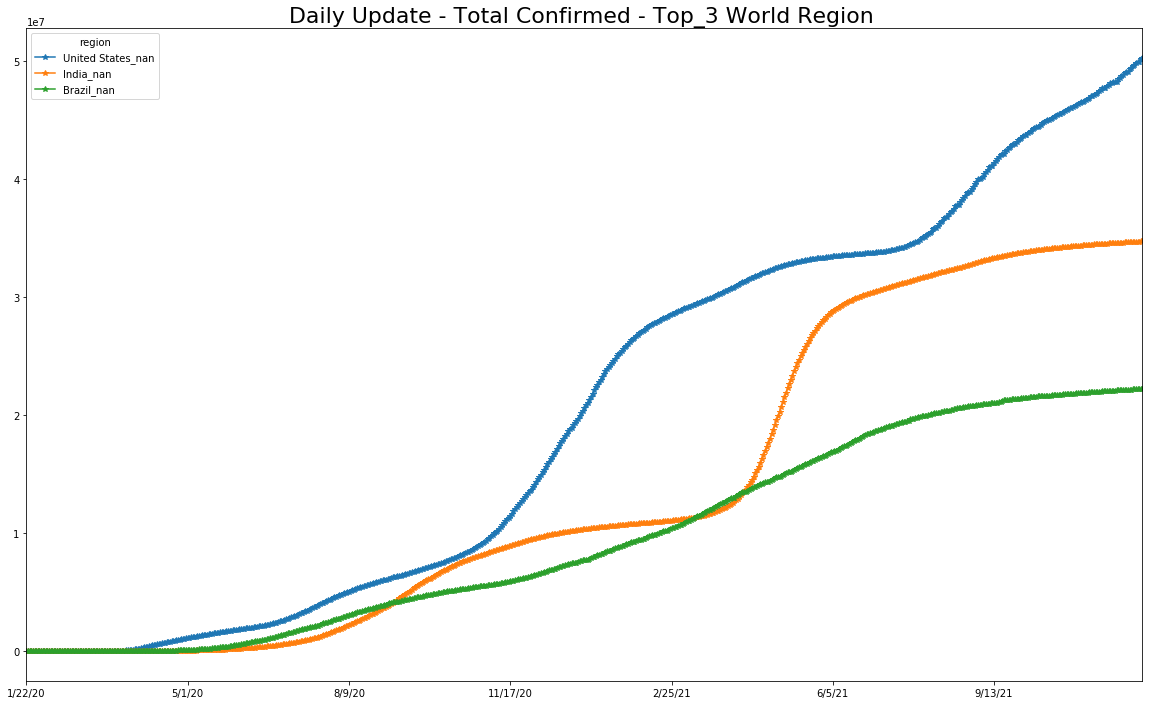

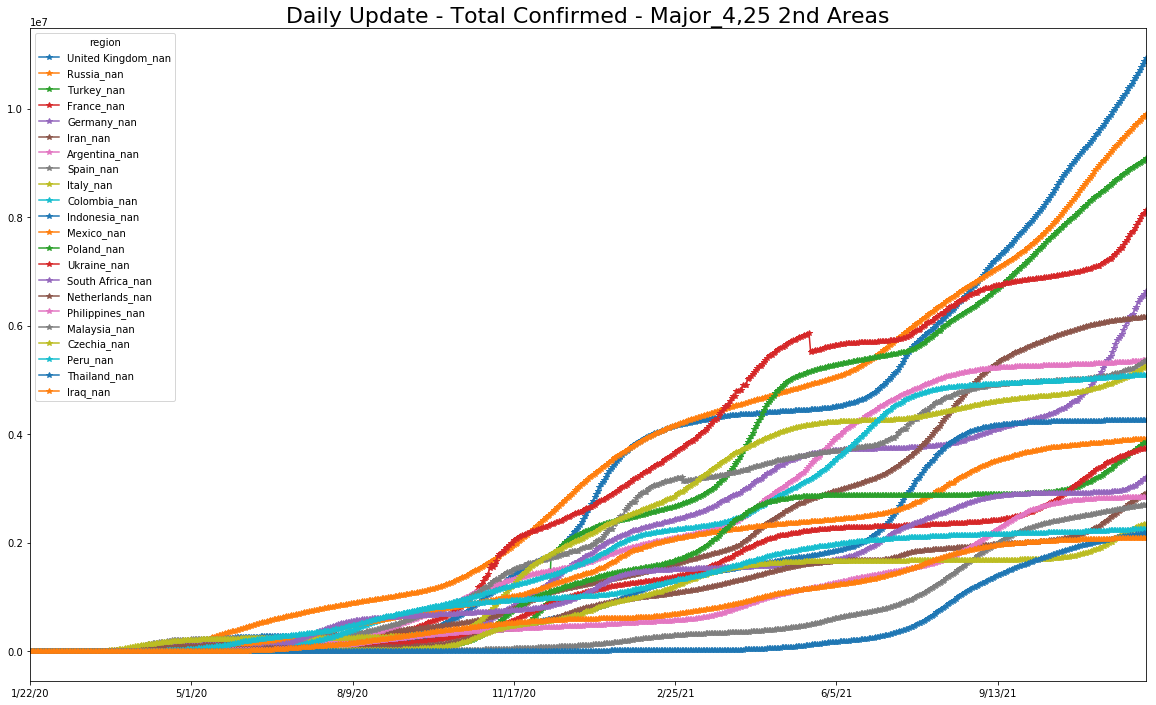

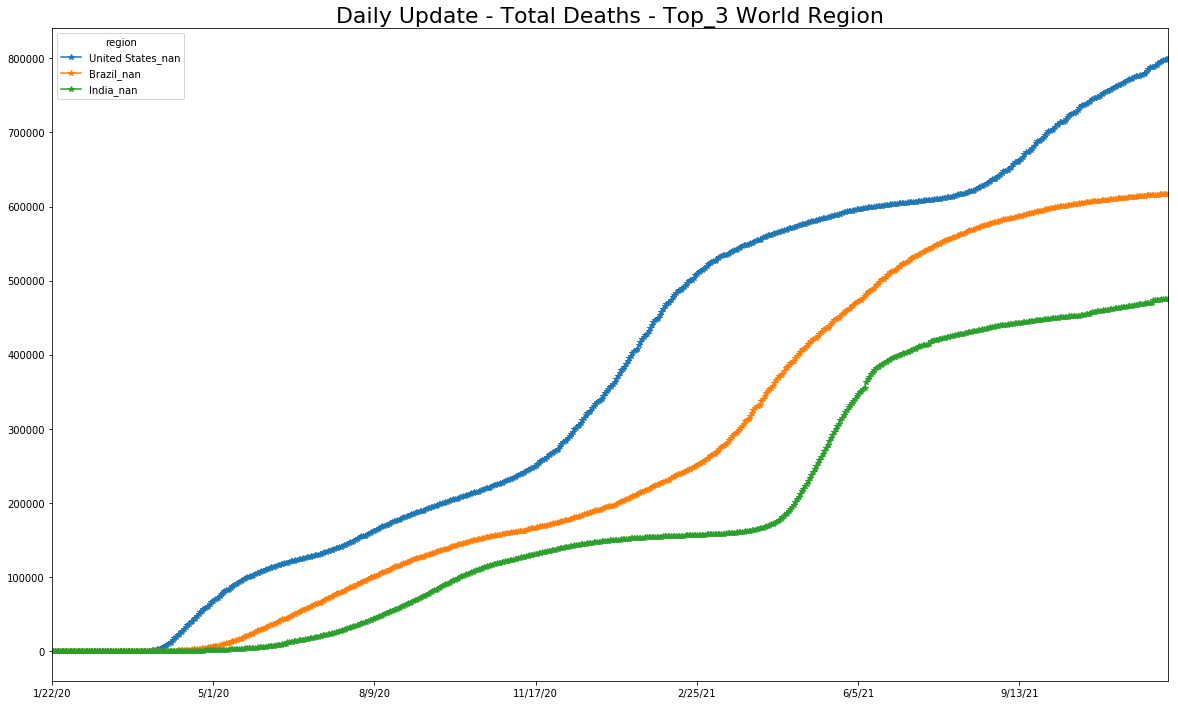

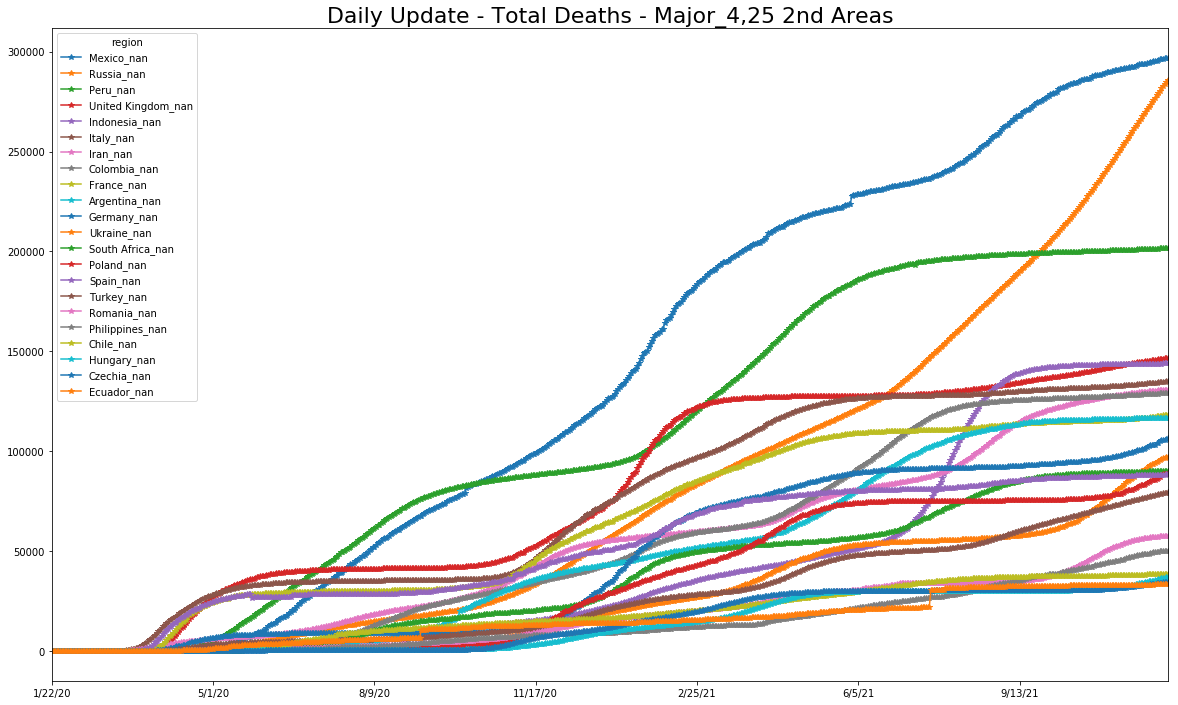

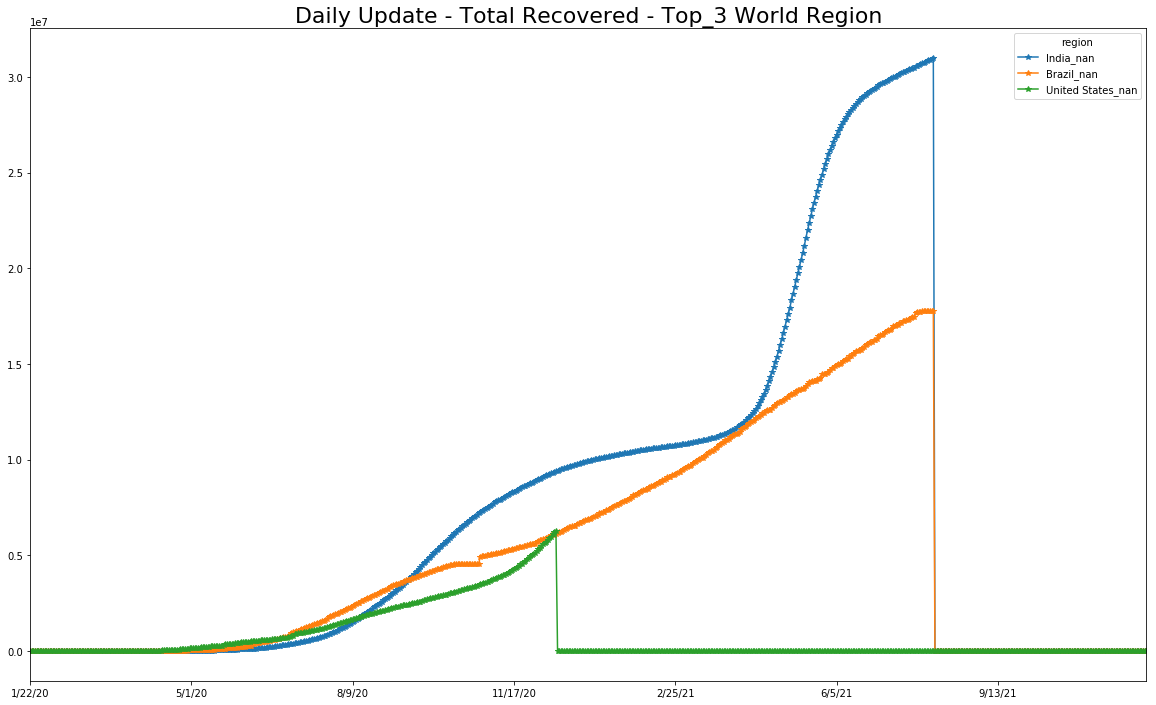

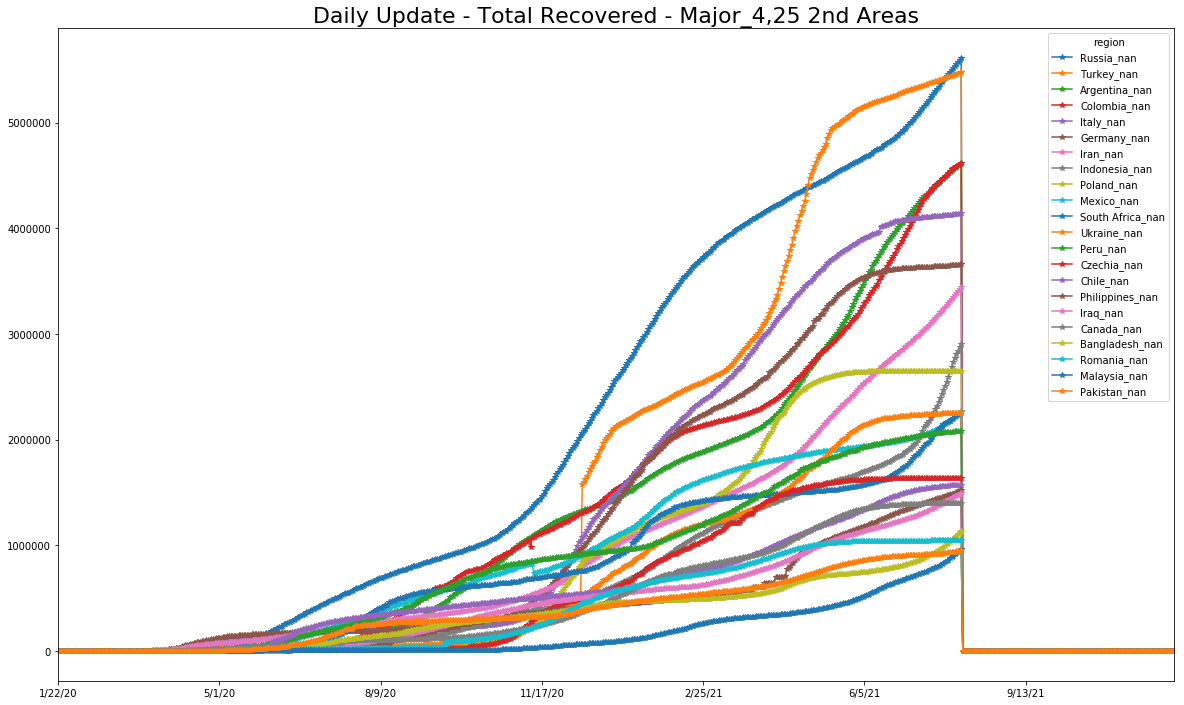

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/12/15


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31420568       149430           85291            3   
4/14/21  ...           31495884       152089           85503            3   
4/15/21  ...           31569794       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/11/21           157858       203524       212652        19440       65397   
12/12/21           157858       203787       212848        19440       65404   
12/13/21           157648       203925       213058        19440       65404   
12/14/21           157660       204301       213288        20136       65431   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/11/21                     4159        5356885       342405   
12/12/21                     4162        5358455       342538   
12/13/21                     4162        5358455       342604   
12/14/21                     4177        5366522       342765   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/11/21                                    2197                      85924   
12/12/21                                    2200                      86453   
12/13/21                                    2204                      87248   
12/14/21                                    2210                      88595   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/11/21  ...           49884847       402383          195524            6   
12/12/21  ...           49921799       402509          195747            6   
12/13/21  ...           50119589       402509          195958            6   
12/14/21  ...           50233338       402978          196094            7   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/11/21         437887      1398413                  463573      10063   
12/12/21         438683      1413051                  463573      10069   
12/13/21         438683      1428428                  464341      10072   
12/14/21         439089      1443648                  464751      10075   

region    Zambia_nan  Zimbabwe_nan  
12/11/21      210959        165002  
12/12/21      211077        167140  
12/13/21      211234        167140  
12/14/21      211705        172012  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
70612 2021-11-16     Zimbabwe_nan     133505            10           109   
70613 2021-11-17     Zimbabwe_nan     133557            67           112   
70614 2021-11-18     Zimbabwe_nan     133593            52           129   
70615 2021-11-19     Zimbabwe_nan     133593            36           155   
70616 2021-11-20     Zimbabwe_nan     133615             0            88   
70617 2021-11-21     Zimbabwe_nan     133647            22            58   
70618 2021-11-22     Zimbabwe_nan     133674            32            54   
70619 2021-11-23     Zimbabwe_nan     133674            27            81   
70620 2021-11-24     Zimbabwe_nan     133747             0            59   
70621 2021-11-25     Zimbabwe_nan     133774            73           100   
70622 2021-11-26     Zimbabwe_nan     133836            27           100   
70623 2021-11-27     Zimbabwe_nan     133836            62           162   
70624 2021-11-28     Zimbabwe_nan     133951             0            89   
70625 2021-11-29     Zimbabwe_nan     134226           115           177   
70626 2021-11-30     Zimbabwe_nan     134625           275           390   
70627 2021-12-01     Zimbabwe_nan     135337           399           789   
70628 2021-12-02     Zimbabwe_nan     136379           712          1386   
70629 2021-12-03     Zimbabwe_nan     137441          1042          2153   
70630 2021-12-04     Zimbabwe_nan     138523          1062          2816   
70631 2021-12-05     Zimbabwe_nan     139046          1082          3186   
70632 2021-12-06     Zimbabwe_nan     139046           523  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
70641 2021-12-15  Zimbabwe_nan          0          4872          7010   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
70641         30411         102.914928         104.248439          121.47655   

       last_day  kalman_prediction  population  infected_rate  min  max  
70641    172012           176392.0    14862924       0.000116  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
70641 2021-12-15  Zimbabwe_nan          0          4872          7010   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
70641         30411         102.914928         104.248439          121.47655   

       last_day  kalman_prediction  population  infected_rate  min  max  
70641    172012           176392.0    14862924       0.000116  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
69157  2021-12-13  Zimbabwe_nan     167140          2138         11323   
69158  2021-12-14  Zimbabwe_nan     172012             0         11323   
69159  2021-12-15  Zimbabwe_nan          0          4872          7010   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
69157         28094         101.295748         107.266864         120.204831   
69158         28094         100.000006         107.266864         120.204831   
69159         30411         102.914928         104.248439         121.476550   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
69157               167140  ...    14862924       0.000112  NaN  NaN   
69158               167140  ...    14862924       0.000112  NaN  NaN   
69159               172012  ...    14862924       0.000116  NaN  NaN   

       population_percentage : infected_rate confirmed  \
69157                                         0.011245   
69158                                         0.011245   
69159                                         0.011573   

       population_percentage : factor 9/10 infected_rate confirmed  \
69157                                           0.101209             
69158                                           0.101209             
69159                                           0.104160             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
69157                  4002.0                         269.260611   
69158                  6052.0                         407.187711   
69159                  4380.0                         294.693023   

       delta : roling 7day AVG  \
69157              4013.428571   
69158              4013.428571   
69159              4344.428571   

       delta : aprox 14-day case notification rate per 100k hab  
69157                                         378.041360         
69158                                         378.041360         
69159                                         409.219613         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
270  United States_nan  1.040790e+13  3.226128e+06  266179.410569


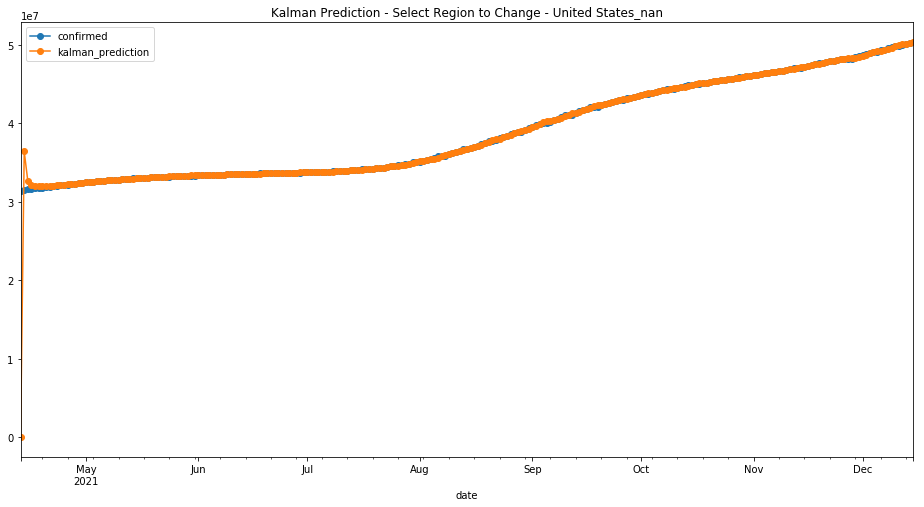

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  4.030990e+11  634900.802368  46341.504065


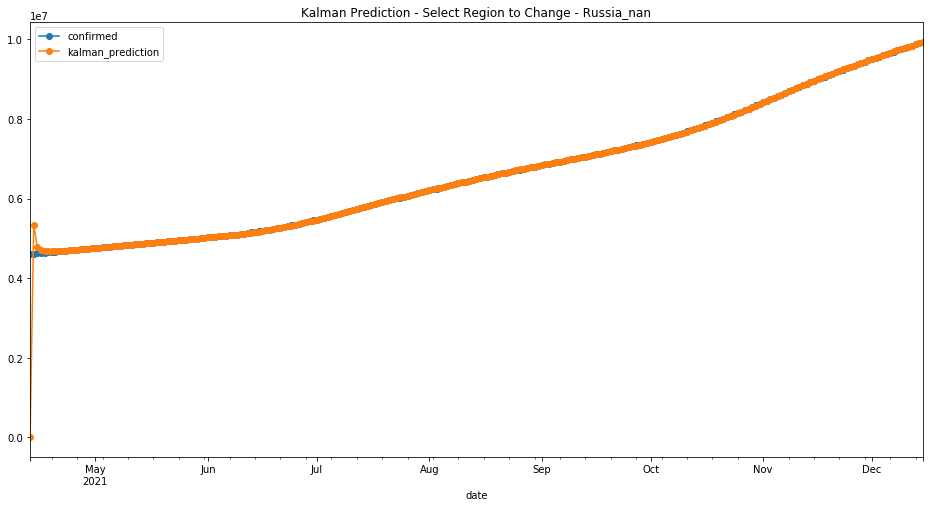

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.021710e+12  1.421868e+06  118021.004065


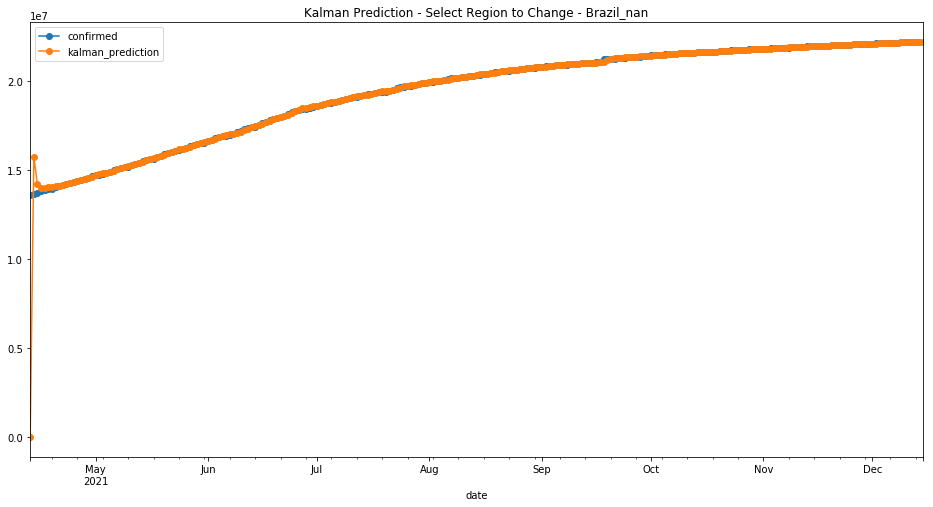

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
269  United Kingdom_nan  4.923080e+11  701646.619846  53593.113821


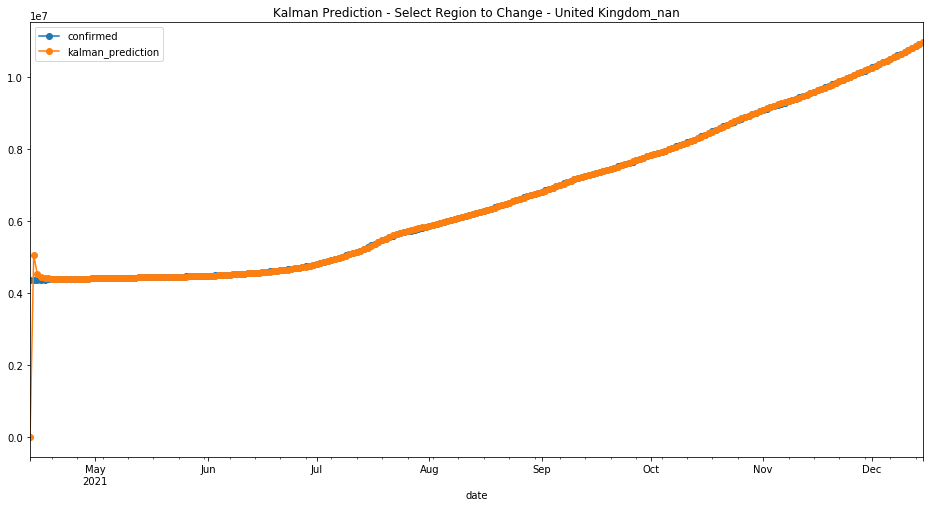

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpr5vlk2oo
  JVM stdout: /tmp/tmpr5vlk2oo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpr5vlk2oo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 1 month and 18 days !!!
H2O cluster name:           H2O_from_python_unknownUser_uc68ok
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-12-08
last_train_date= 2021-12-14
first_bootstrap_date= 2021-12-06
boost_bootstrap_date= 2021-12-11
first_test_date= 2021-12-05
last_test_date= 2021-12-15
first_valid_date= 2021-12-13


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   158455.0     157499 2021-12-06  Afghanistan_nan
1   158479.0     157508 2021-12-07  Afghanistan_nan
2   158511.0     157542 2021-12-08  Afghanistan_nan
3   158529.0     157585 2021-12-09  Afghanistan_nan
4   158564.0     157858 2021-12-10  Afghanistan_nan
5   158690.0     157858 2021-12-11  Afghanistan_nan
6   158870.0     157858 2021-12-12  Afghanistan_nan
7   158915.0     157648 2021-12-13  Afghanistan_nan
8   158850.0     157660 2021-12-14  Afghanistan_nan
9   158709.0          0 2021-12-15  Afghanistan_nan
10  202372.0     201902 2021-12-06      Albania_nan
11  202644.0     202295 2021-12-07      Albania_nan
12  202924.0     202641 2021-12-08      Albania_nan
13  203271.0     202863 2021-12-09      Albania_nan
14  203557.0     203215 2021-12-10      Albania_nan
15  203841.0     203524 2021-12-11      Albania_nan
16  204158.0     203787 2021-12-12      Albania_nan
17  204445.0     203925 2021-12-13      Albania_nan
18  204652.0     204301 2021-12-14      Albania_nan
19  204887.0          0 2021-12-15      Albania_nan
20  212572.0     211662 2021-12-06      Algeria_nan
21  212754.0     211859 2021-12-07      Algeria_nan
22  212946.0     212047 2021-12-08      Algeria_nan
23  213139.0     212224 2021-12-09      Algeria_nan
24  213322.0     212434 2021-12-10      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  603763.0     603254 2021-12-11  Azerbaijan_nan
176  604847.0     604480 2021-12-12  Azerbaijan_nan
177  605998.0     604998 2021-12-13  Azerbaijan_nan
178  606700.0     605920 2021-12-14  Azerbaijan_nan
179  607480.0          0 2021-12-15  Azerbaijan_nan
180   23409.0      22839 2021-12-06     Bahamas_nan
181   23370.0      22846 2021-12-07     Bahamas_nan
182   23397.0      22846 2021-12-08     Bahamas_nan
183   23419.0      22859 2021-12-09     Bahamas_nan
184   23387.0      22881 2021-12-10     Bahamas_nan
185   23377.0      22881 2021-12-11     Bahamas_nan
186   23453.0      22881 2021-12-12     Bahamas_nan
187   23454.0      22907 2021-12-13     Bahamas_nan
188   23392.0      22907 2021-12-14     Bahamas_nan
189   23479.0          0 2021-12-15     Bahamas_nan
190  277302.0     277856 2021-12-06     Bahrain_nan
191  277325.0     277894 2021-12-07     Bahrain_nan
192  277354.0     277935 2021-12-08     Bahrain_nan
193  277391.0     277964 2021-12-09     Bahrain_nan
194  277426.0     277997 2021-12-10     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   665641.0     665125 2021-12-06  Belarus_nan
221   667154.0     666137 2021-12-07  Belarus_nan
222   668300.0     667893 2021-12-08  Belarus_nan
223   669775.0     669631 2021-12-09  Belarus_nan
224   671353.0     671432 2021-12-10  Belarus_nan
225   673067.0     673269 2021-12-11  Belarus_nan
226   674897.0     674723 2021-12-12  Belarus_nan
227   676512.0     675734 2021-12-13  Belarus_nan
228   677730.0     676512 2021-12-14  Belarus_nan
229   678593.0          0 2021-12-15  Belarus_nan
230  1852333.0    1868906 2021-12-06  Belgium_nan
231  1880420.0    1879784 2021-12-07  Belgium_nan
232  1892893.0    1898498 2021-12-08  Belgium_nan
233  1911688.0    1914527 2021-12-09  Belgium_nan
234  1929099.0    1929772 2021-12-10  Belgium_nan
235  1945101.0    1929772 2021-12-11  Belgium_nan
236  1949150.0    1929772 2021-12-12  Belgium_nan
237  1949364.0    1959193 2021-12-13  Belgium_nan
238  1968894.0    1968269 2021-12-14  Belgium_nan
239  1978251.0          0 2021-12-15  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  88197511038.37444
# MSE on the validation data =  42494393897345.33
# R^2 on the training data =  0.9987445863911111
# R^2 on the validation data =  0.4210416923553957


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1639546904678_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 88197511038.37444
RMSE: 296980.6576839213
MAE: 16104.125143201767
RMSLE: 0.4198392795890206
Mean Residual Deviance: 88197511038.37444

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 42494393897345.33
RMSE: 6518772.42257661
MAE: 1802748.0942075427
RMSLE: 8.060613234535243
Mean Residual Deviance: 42494393897345.33
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2021-12-15 05:41:54  0.071 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2021-12-15 05:41:54  0.435 sec   1.0                535479.1002592599   36707.63113919076   286737866814.46655   6533050.639150155   1811352.3376696475  42680750653700.25
     2021-12-15 05:41:55  0.642 sec   2.0                435254.1324874342   34435.84002508938   189446159847.38892   6510916.119827562   1797846.0391626444  42392028719430.4
     2021-12-15 05:41:55  0.935 sec   3.0                408985.8164498379   34383.97906295295   167269398057.14047   6521499.654147669   1803223.3129040143  42529957739048.164
     2021-12-15 05:41:55  1.255 sec   4.0                390255.209214477    32850.45174621953   152299128319.03522   6519579.596308143   1803242.113416964   42504918112597.45
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2021-12-15 05:42:06  12.143 sec  162.0              300767.8774823518   17901.50426472983   90461316125.23898    6529332.193183487   1801972.0453788037  42632178888942.29
     2021-12-15 05:42:10  16.167 sec  248.0              297821.46482154325  17127.3535954287    88697624908.44974    6526275.3558788635  1803428.7000144194  42592270020751.78
     2021-12-15 05:42:14  20.174 sec  334.0              301697.6219196727   16828.78686351261   91021455071.98578    6521833.597312347   1803092.982729777   42534313471032.11
     2021-12-15 05:42:18  24.180 sec  418.0              303013.0198392511   16557.917356442984  91816890192.10239    6519652.1458861     1802710.2859382303  42505864103357.23
     2021-12-15 05:42:22  28.178 sec  500.0              296980.6576839213   16104.125143201767  88197511038.37444    6518772.42257661    1802748.0942075427  42494393897345.33


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.05874e+20            1                    0.350666
last_day           8.74584e+19            0.826061             0.289672
region             6.70474e+19            0.633275             0.222068
7_day_change       1.70134e+19            0.160695             0.0563503
3_day_change       1.13754e+19            0.107443             0.0376765
1_day_change       7.68023e+18            0.0725412            0.0254378
infected_rate      3.24882e+18            0.0306857            0.0107605
7_day_change_rate  9.24832e+17            0.00873521           0.00306315
3_day_change_rate  8.60506e+17            0.00812764           0.00285009
1_day_change_rate  4.3941e+17             0.00415031           0.00145537

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.058740e+20           1.000000    0.350666
1           last_day         8.745839e+19           0.826061    0.289672
2             region         6.704738e+19           0.633275    0.222068
3       7_day_change         1.701341e+19           0.160695    0.056350
4       3_day_change         1.137537e+19           0.107443    0.037676
5       1_day_change         7.680227e+18           0.072541    0.025438
6      infected_rate         3.248822e+18           0.030686    0.010760
7  7_day_change_rate         9.248322e+17           0.008735    0.003063
8  3_day_change_rate         8.605059e+17           0.008128    0.002850
9  1_day_change_rate         4.394095e+17           0.004150    0.001455

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


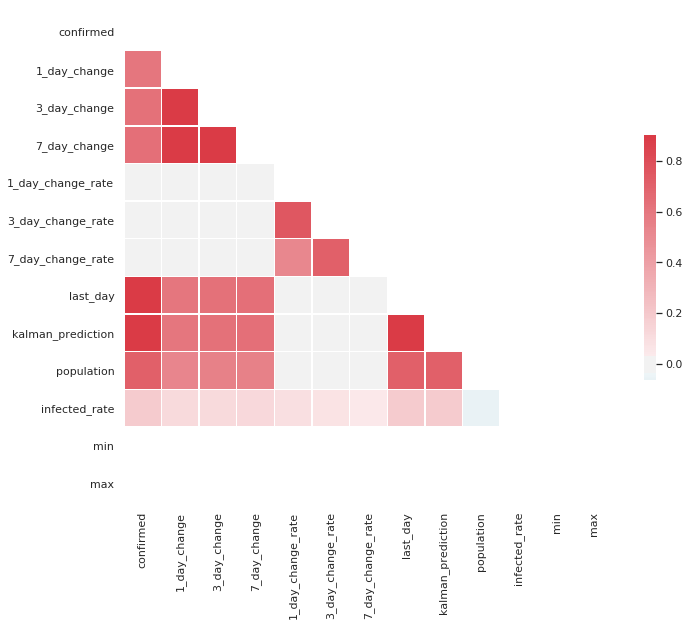

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.607669
3_day_change         0.627921
7_day_change         0.636807
1_day_change_rate    0.019208
3_day_change_rate    0.013011
7_day_change_rate    0.005862
last_day             0.994752
kalman_prediction    0.995754
population           0.712092
infected_rate        0.186659
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


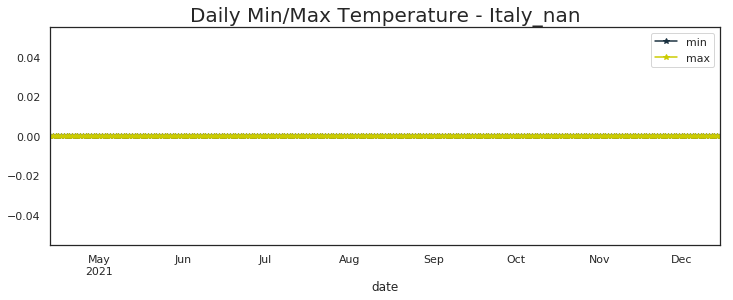

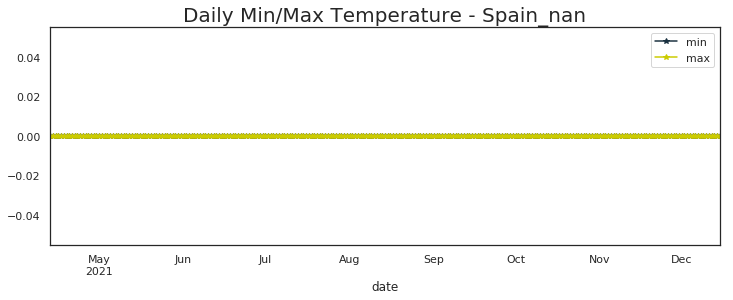

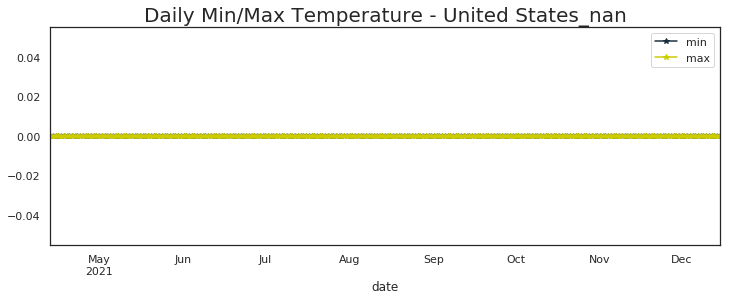

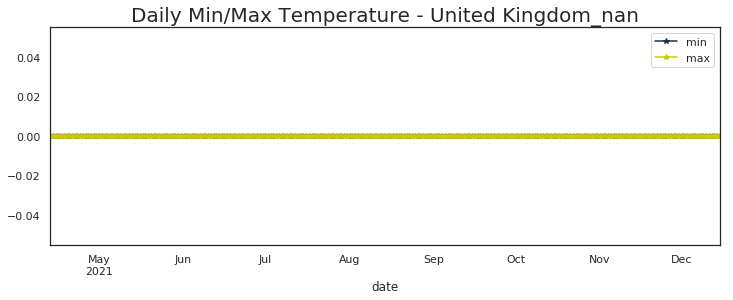

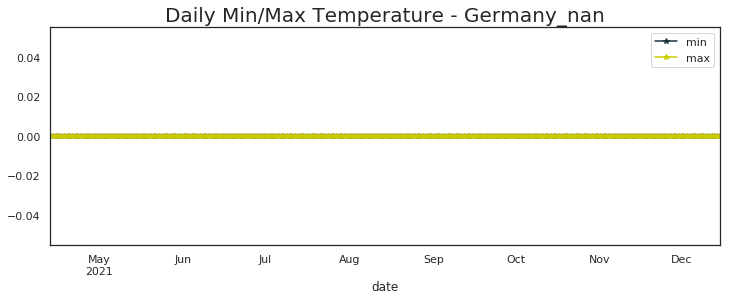

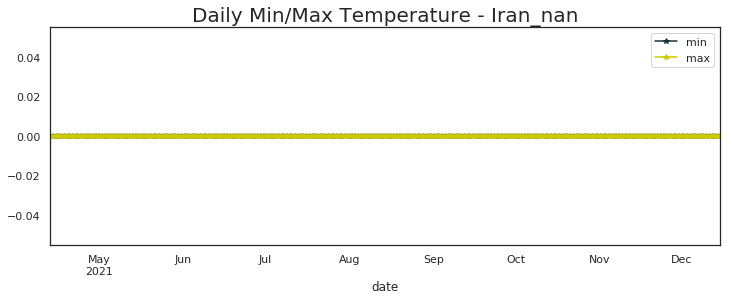

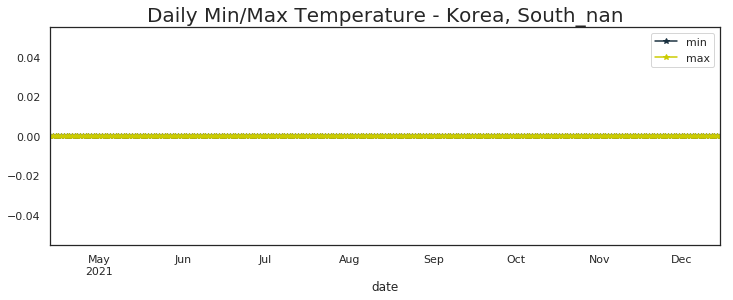

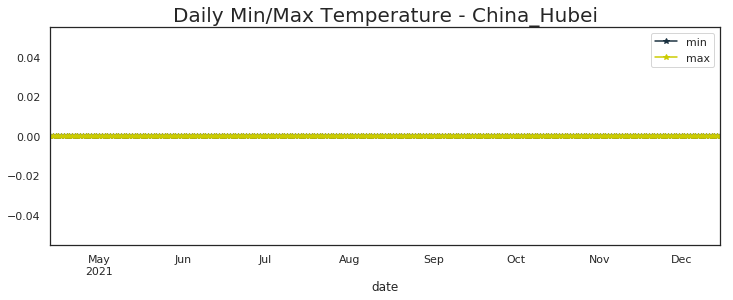

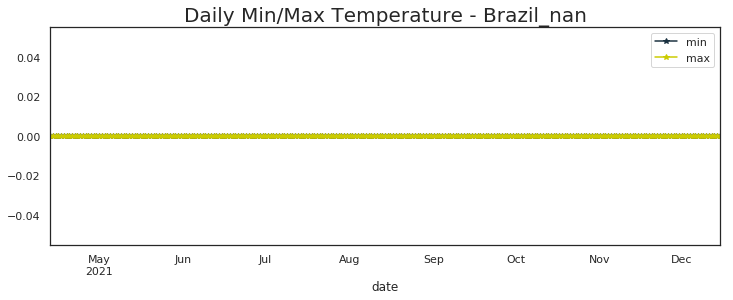

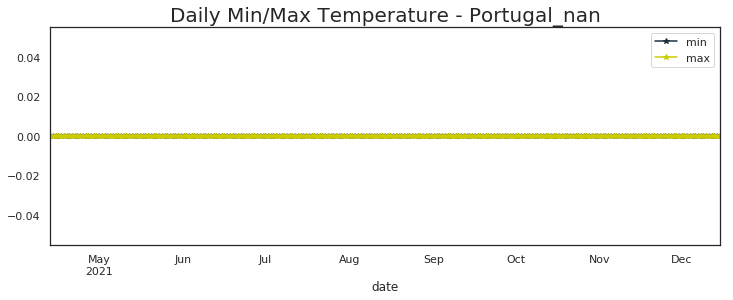

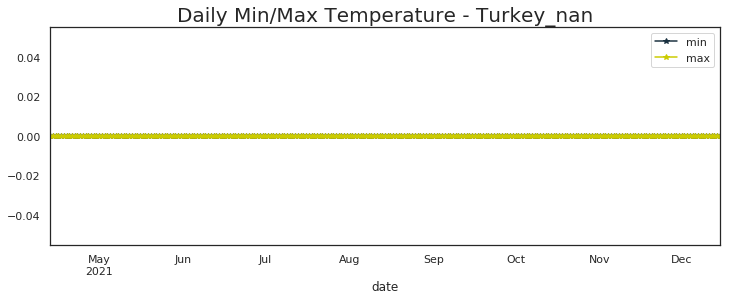

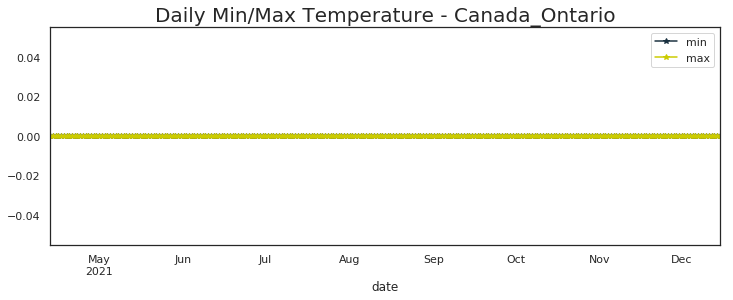

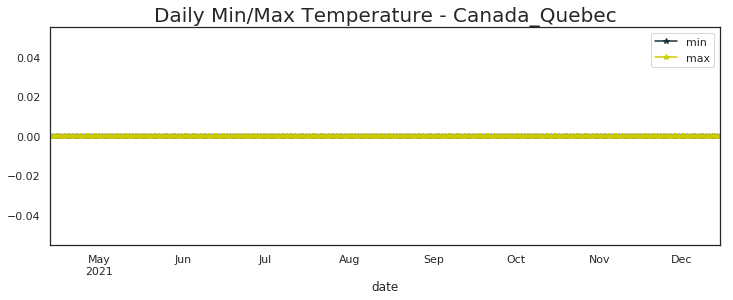

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
France_nan                  0.0  0.0
Germany_nan                 0.0  0.0
Iran_nan                    0.0  0.0
Argentina_nan               0.0  0.0
Spain_nan                   0.0  0.0
Italy_nan                   0.0  0.0
Colombia_nan                0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Poland_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
South Africa_nan            0.0  0.0
Netherlands_nan             0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Czechia_nan                 0.0  0.0
Peru_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Ir

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

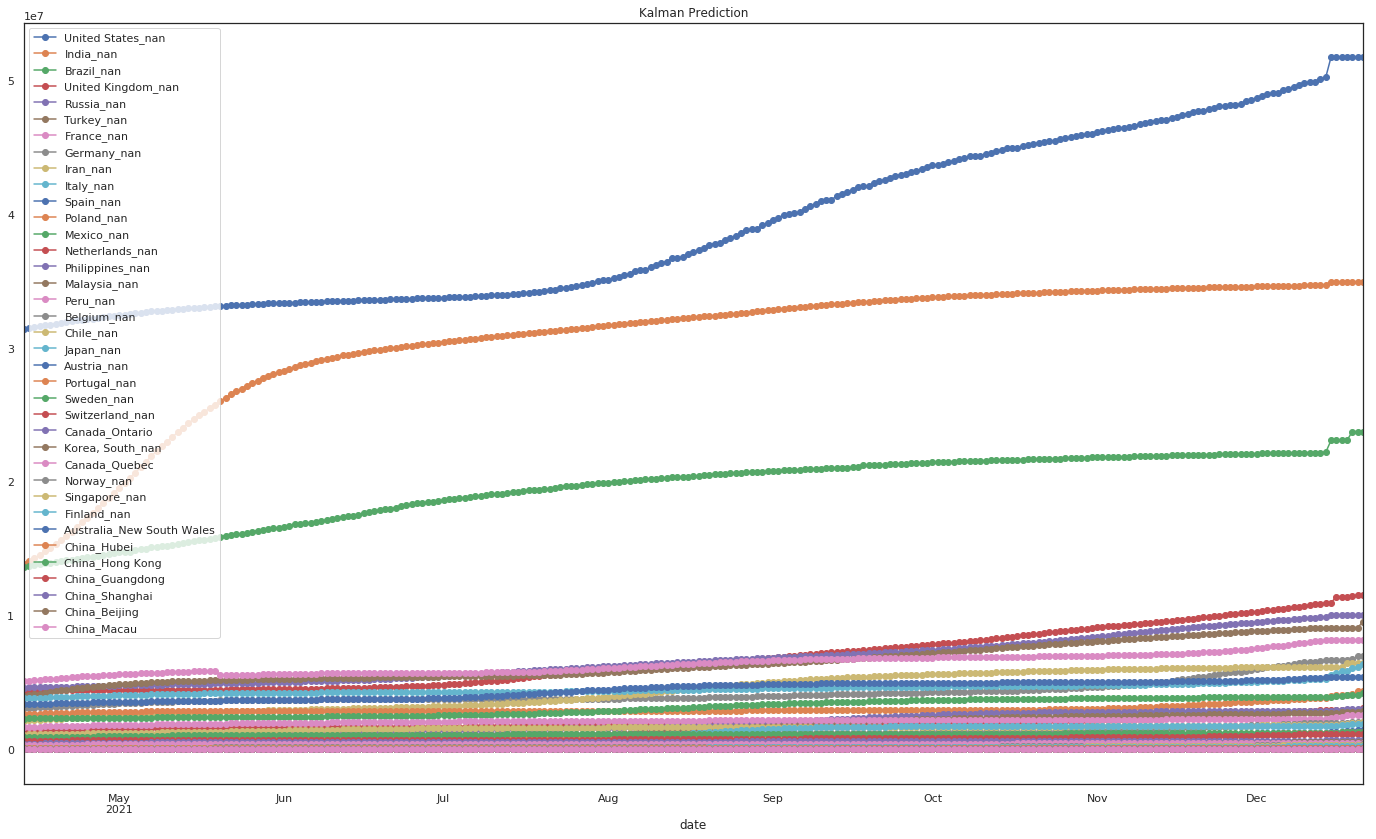

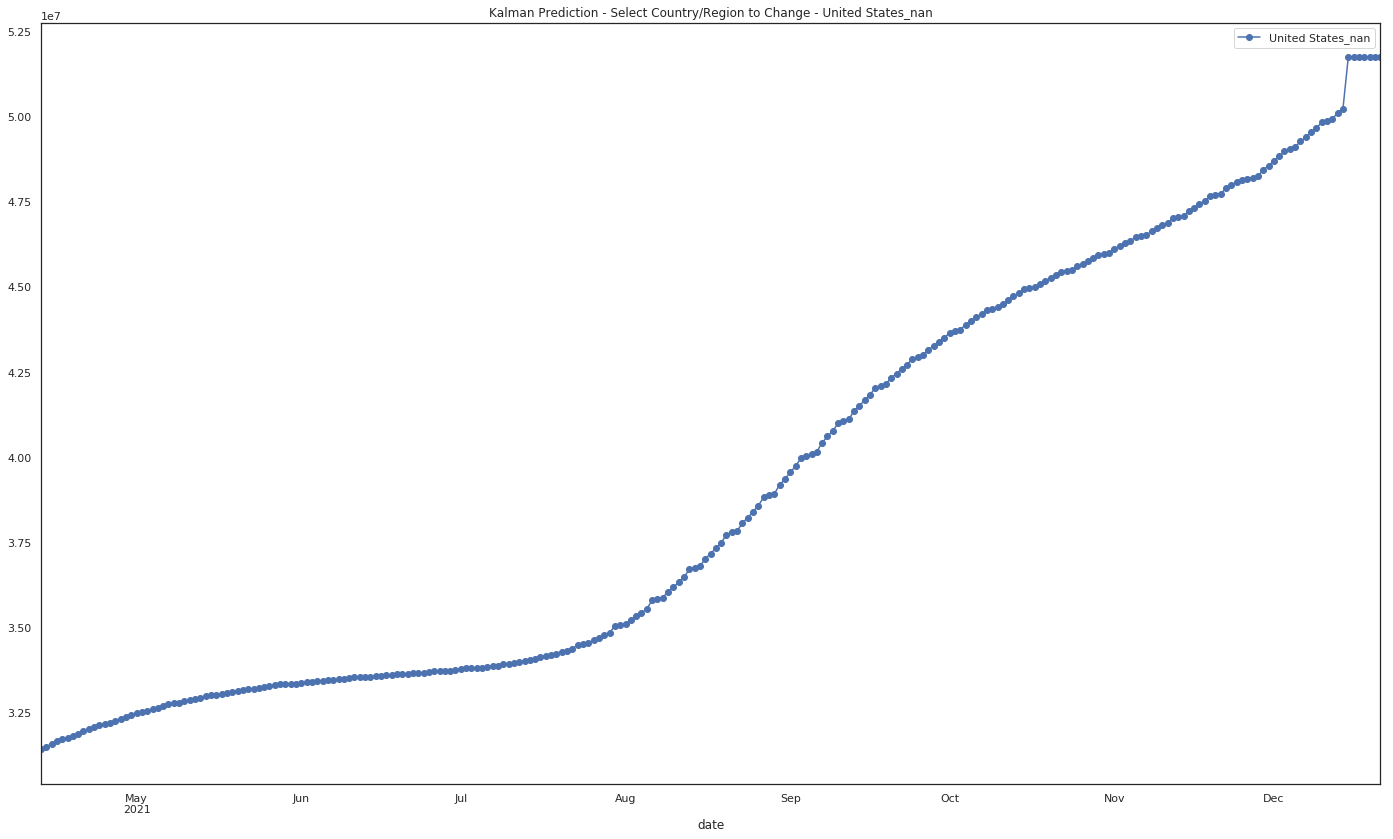

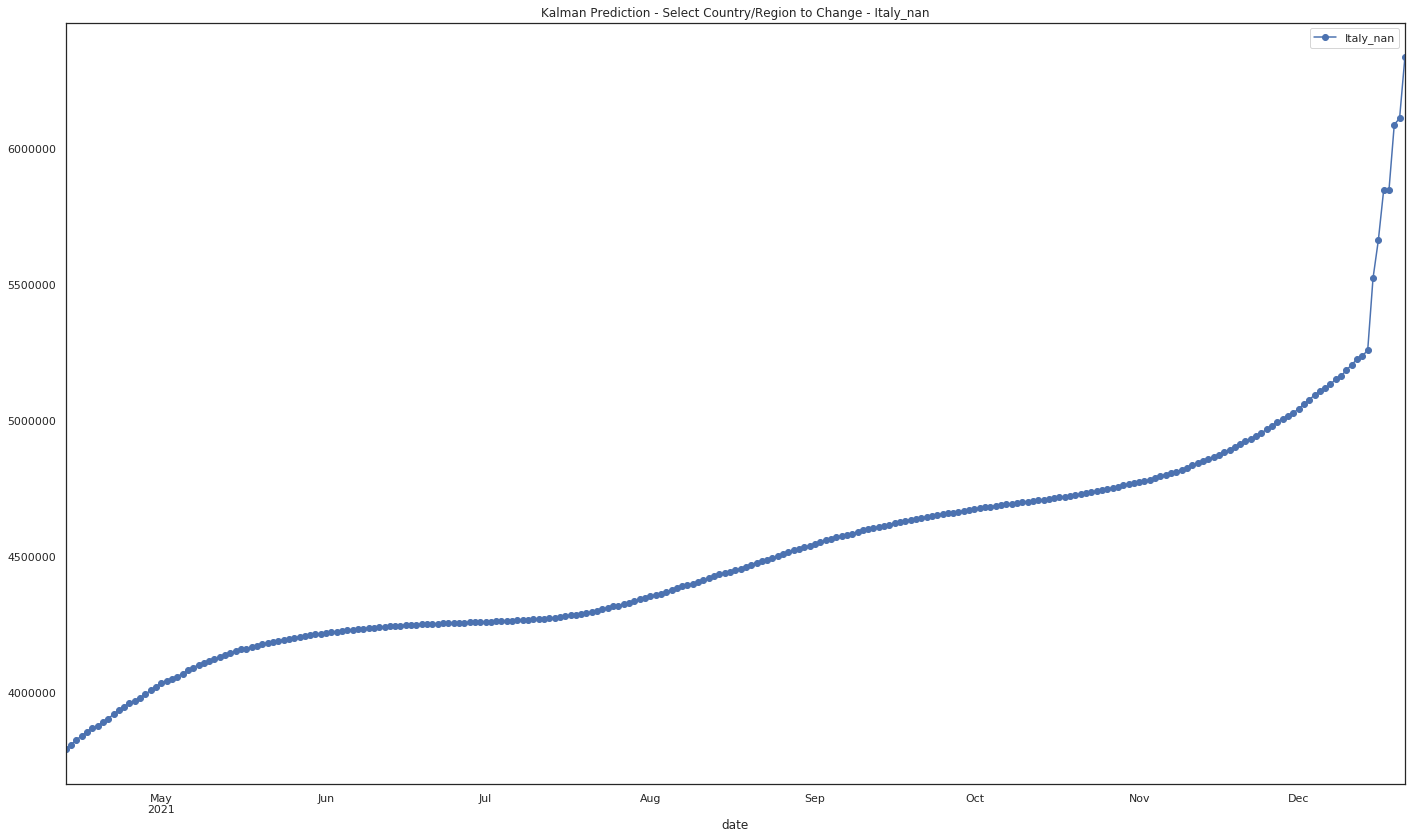

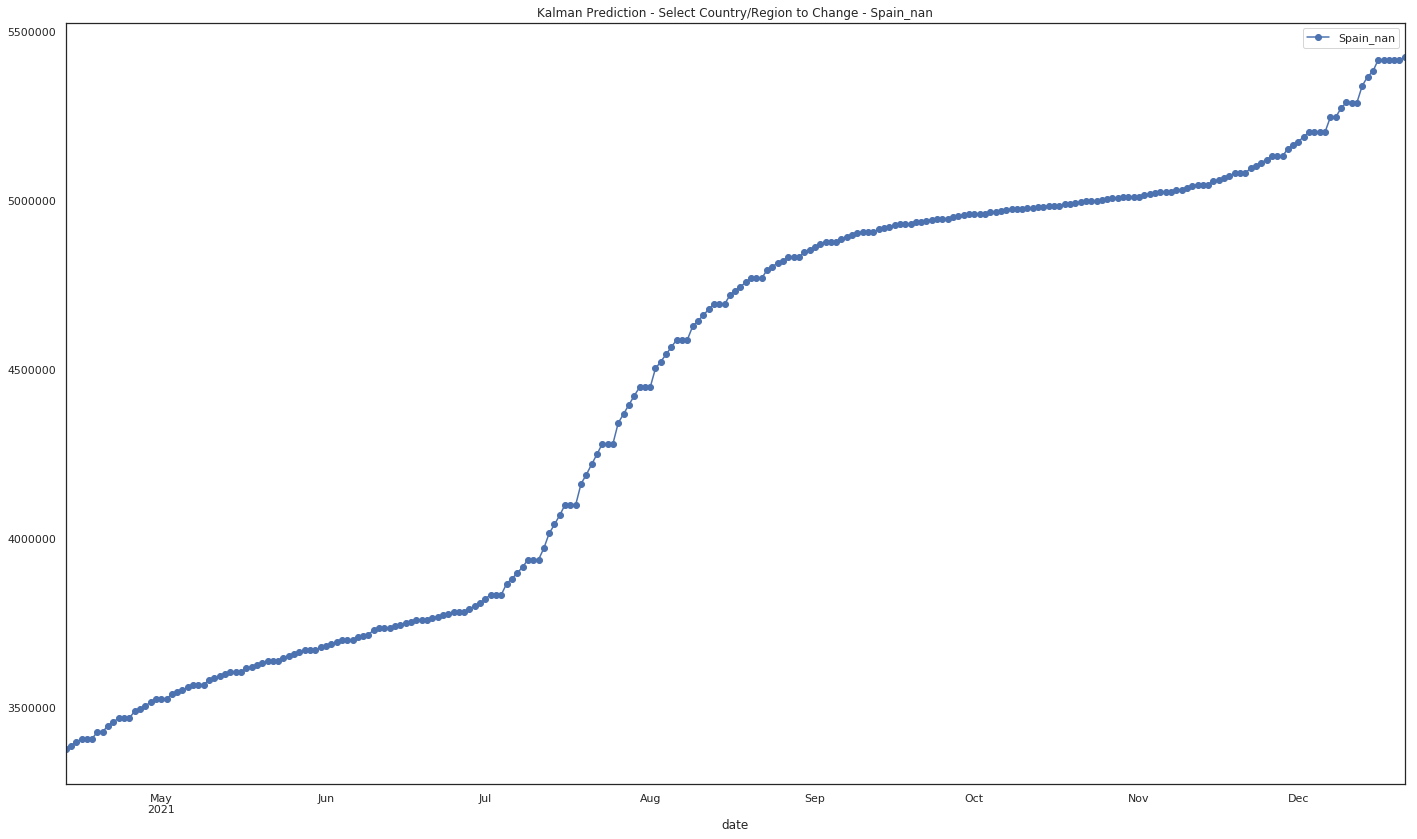

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


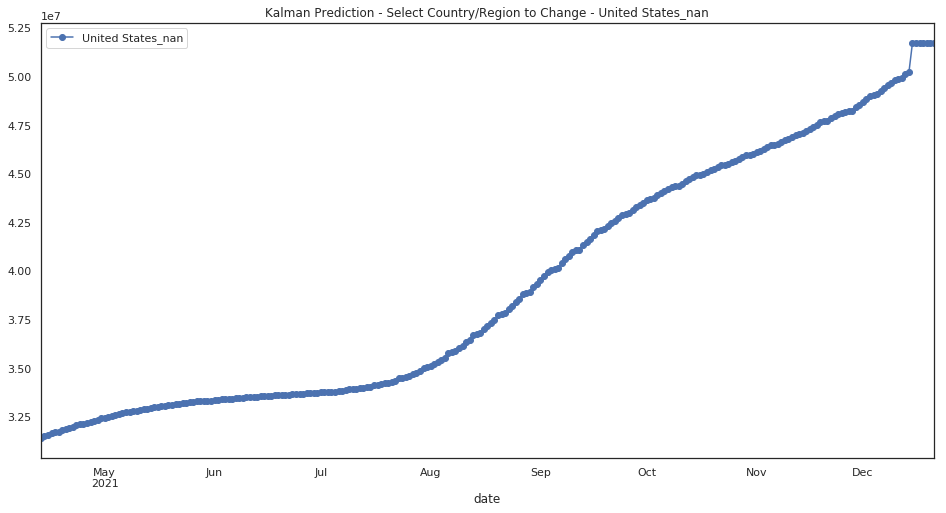

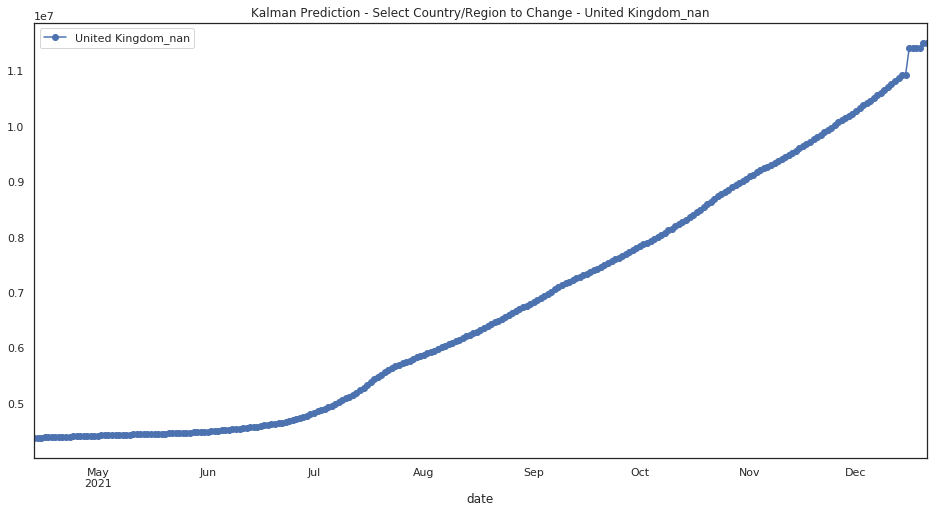

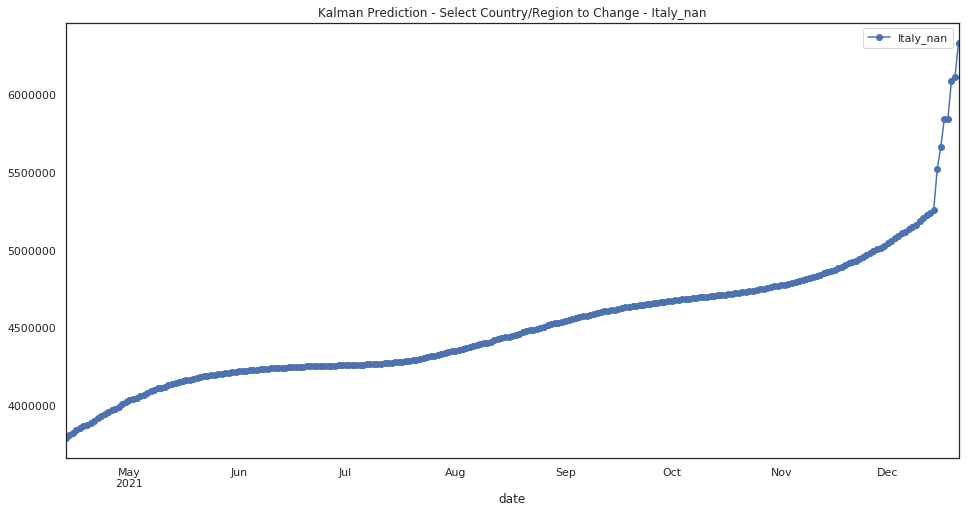

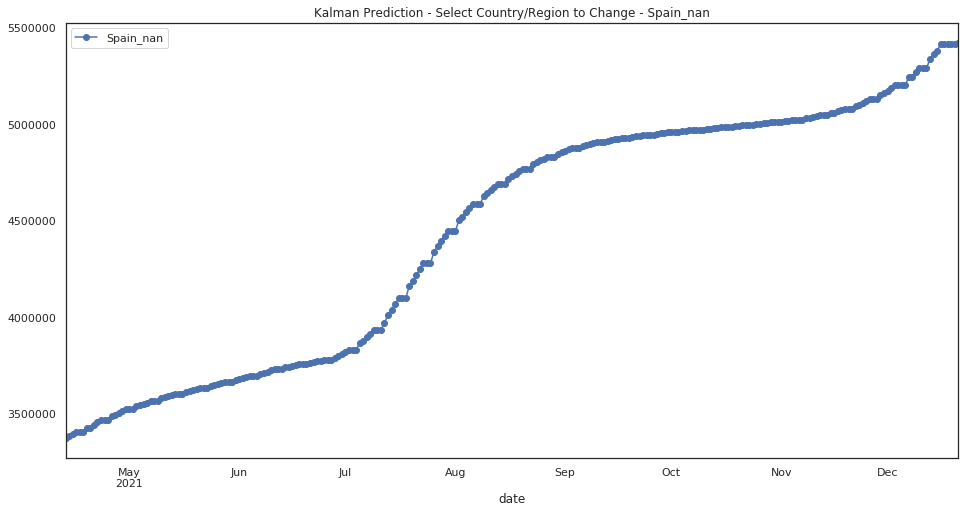

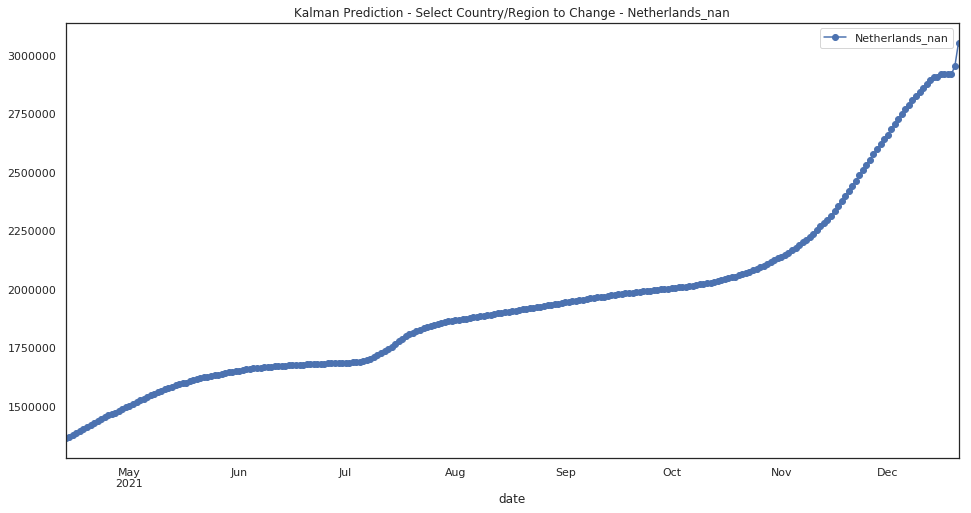

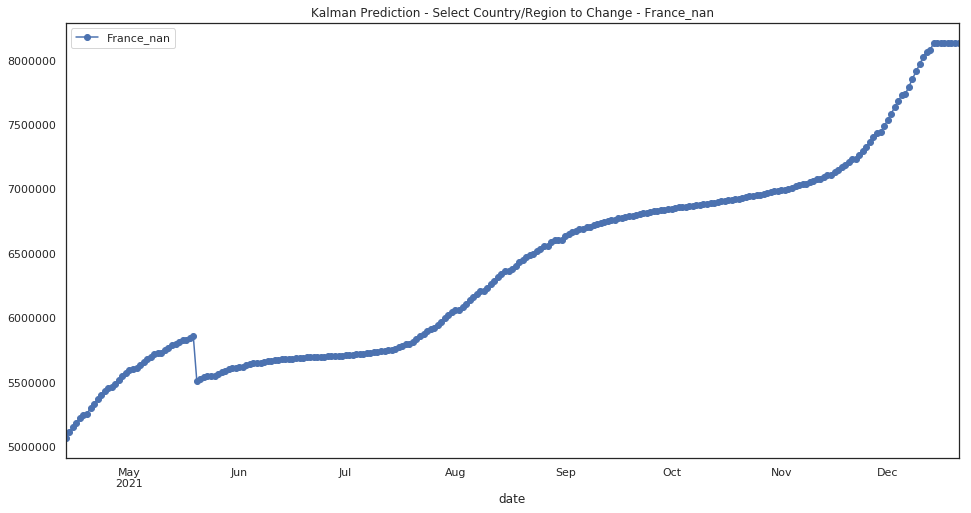

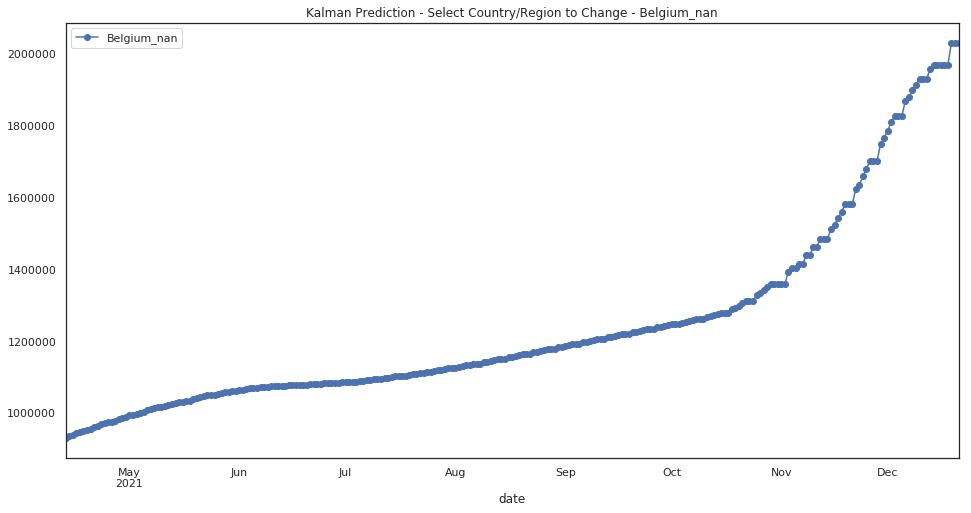

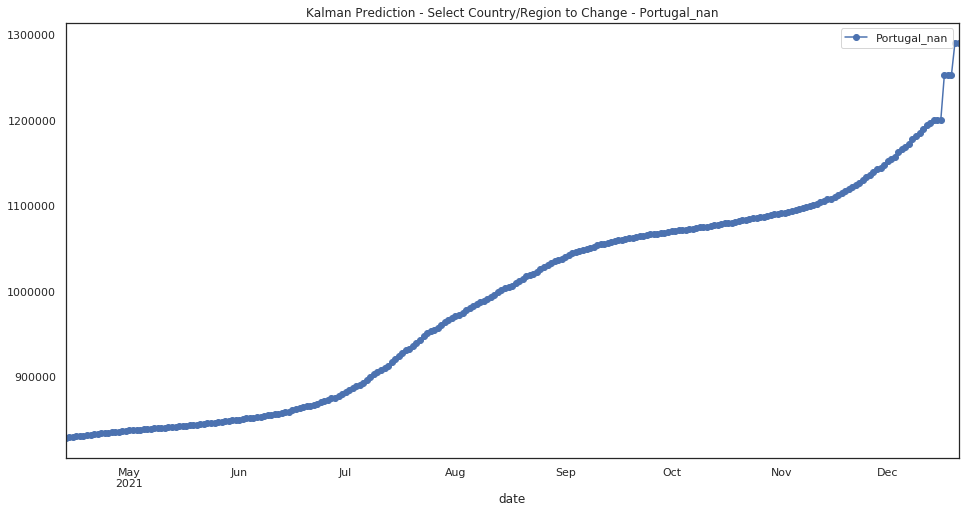

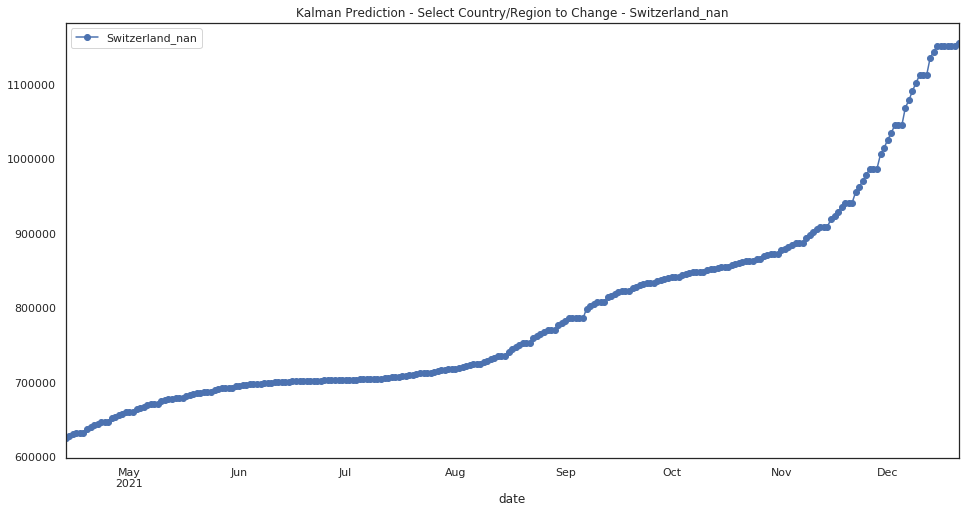

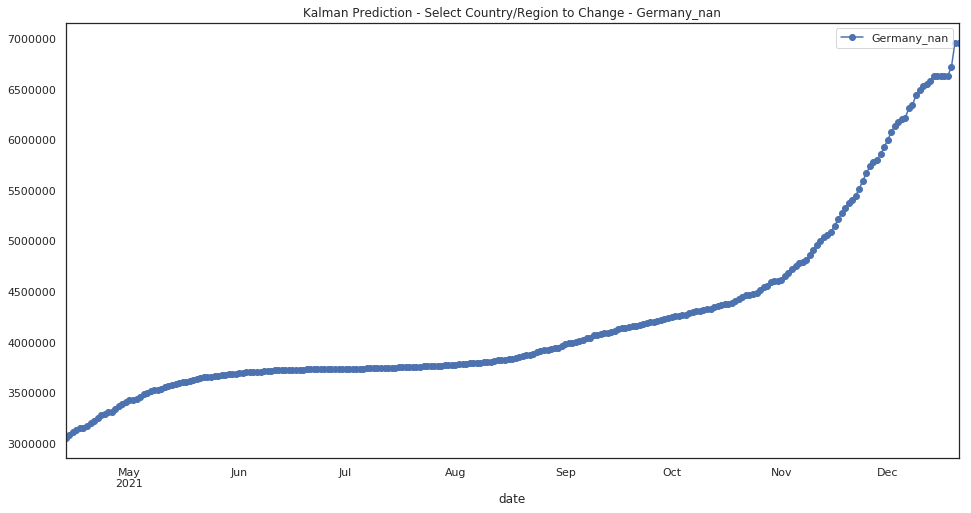

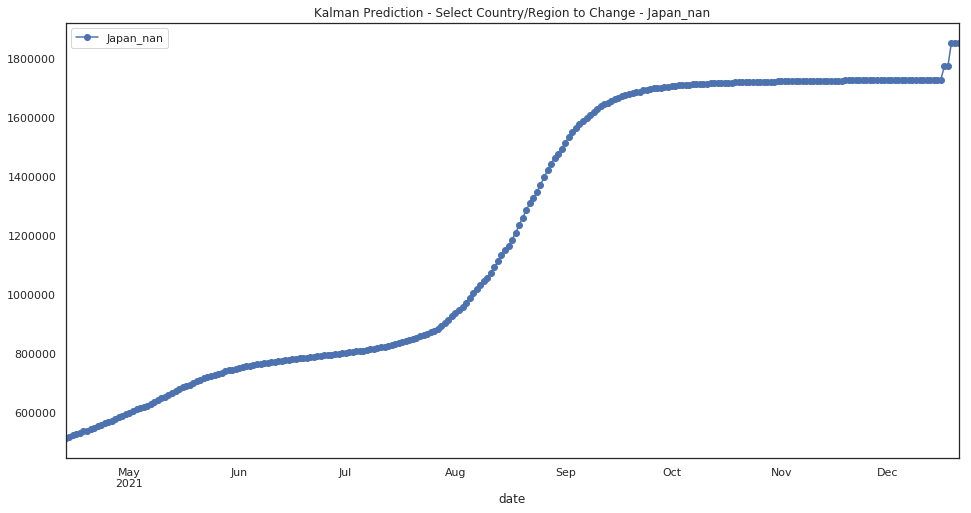

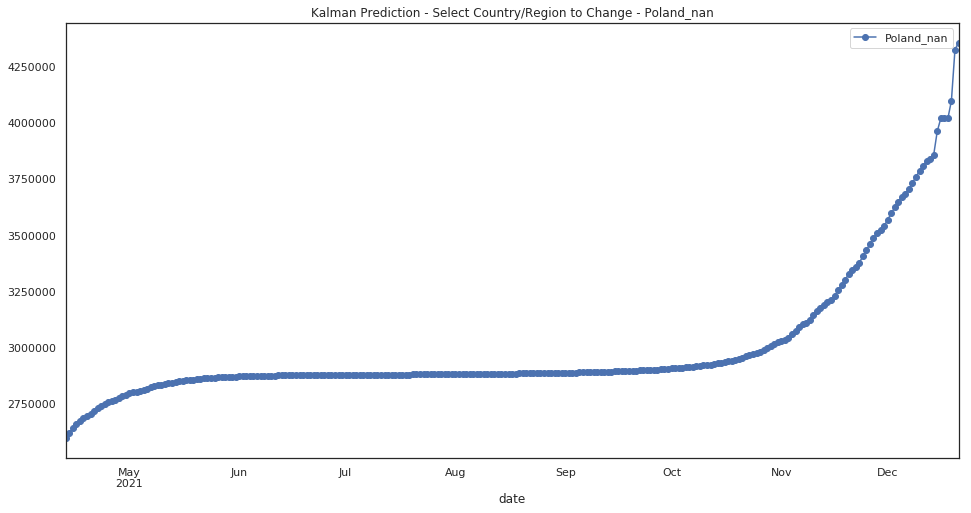

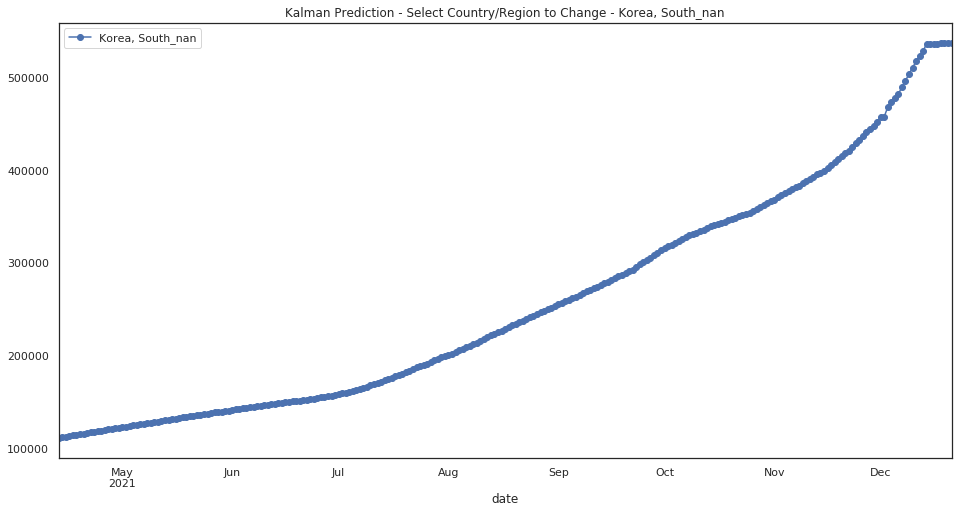

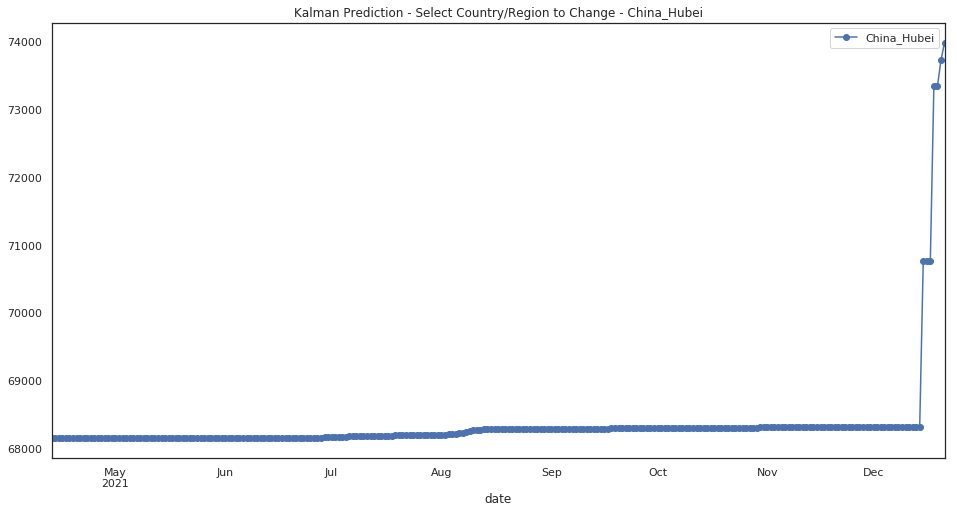

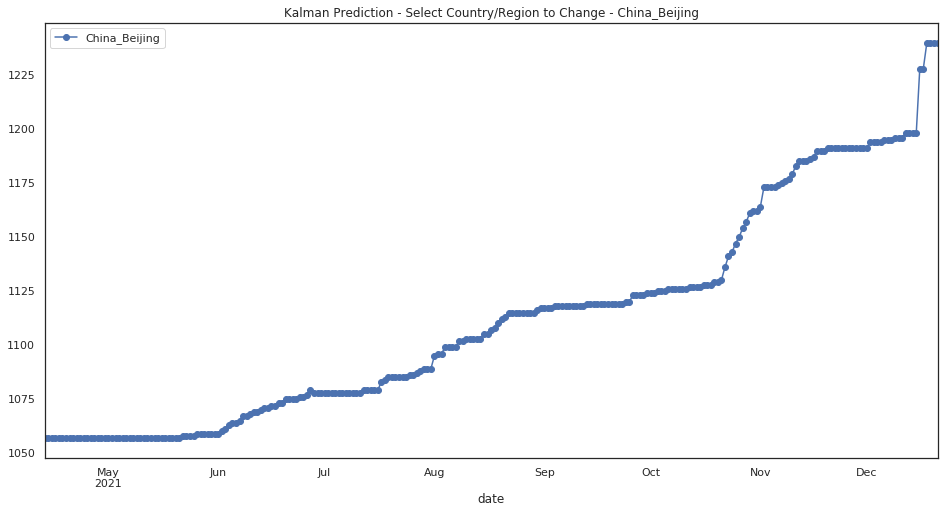

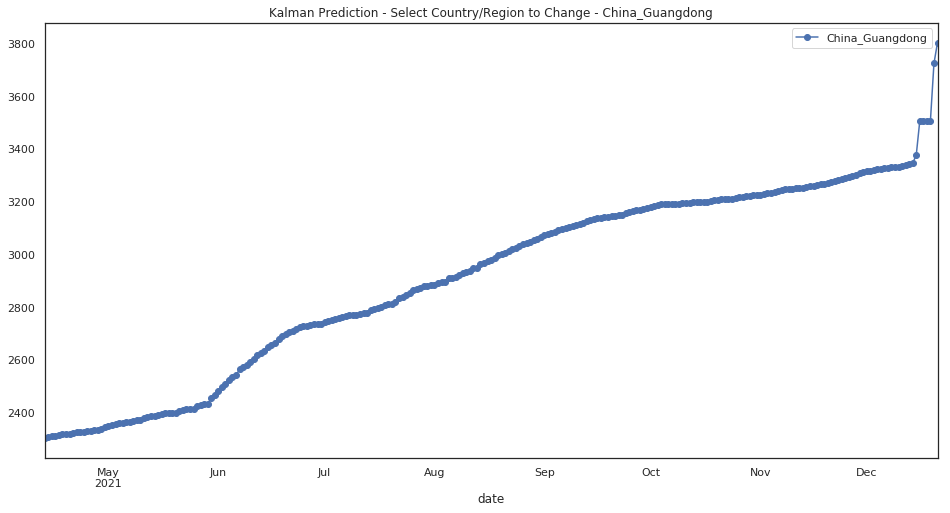

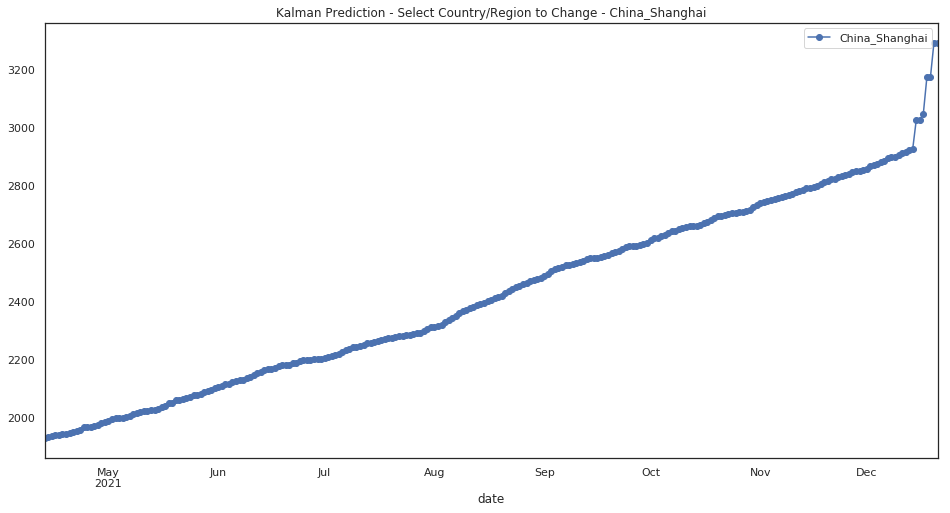

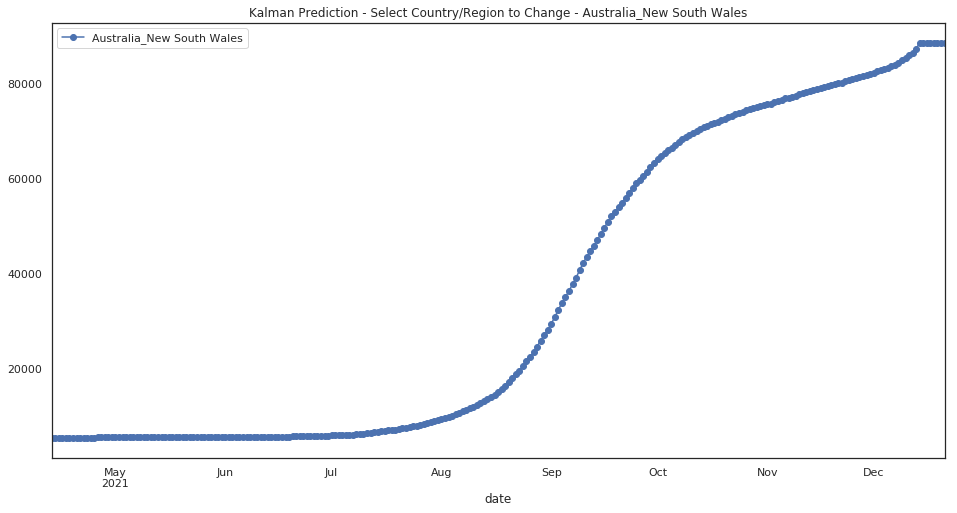

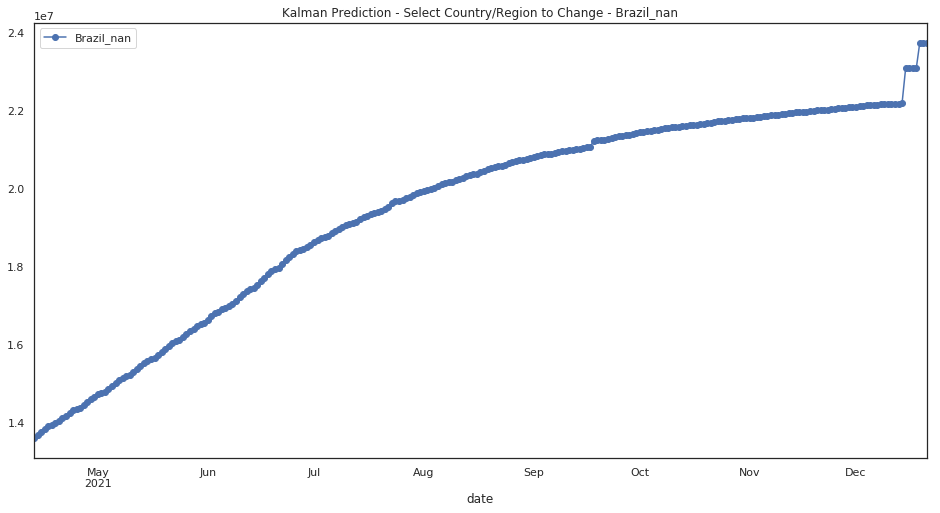

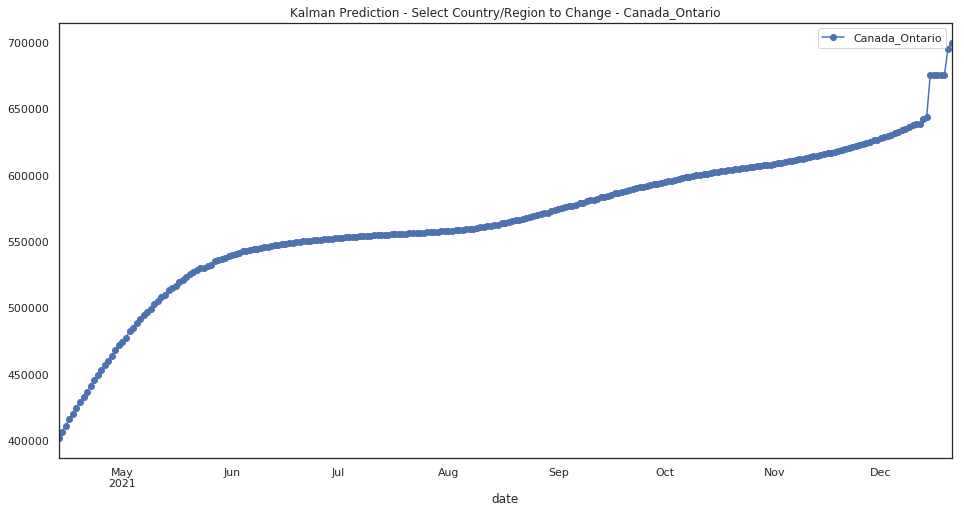

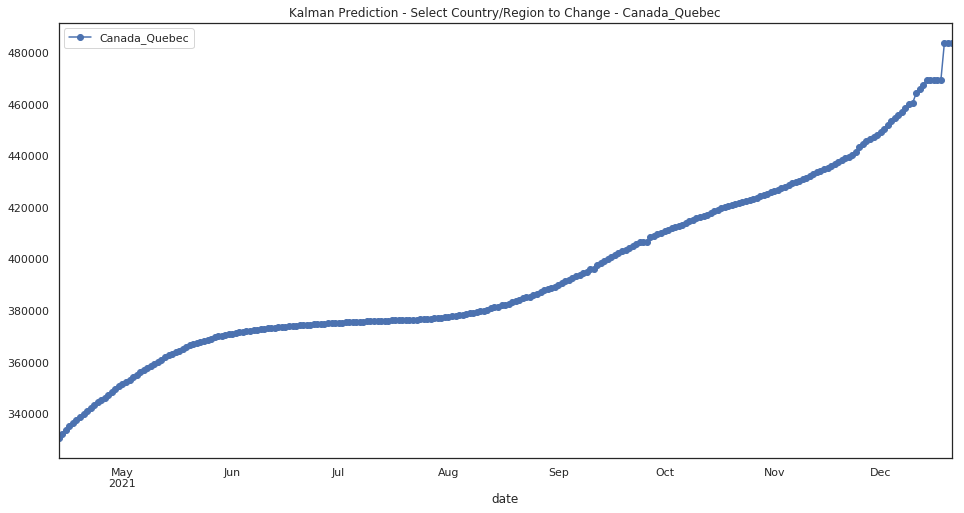

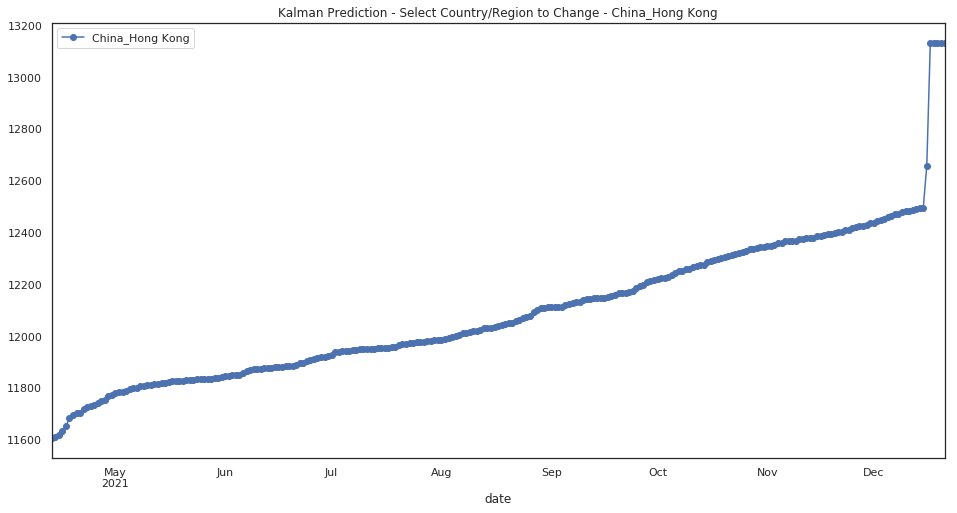

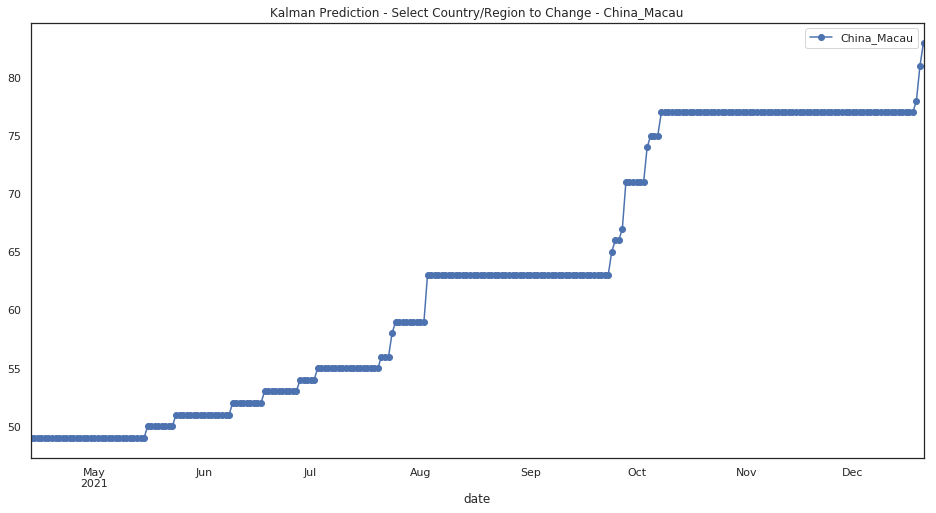

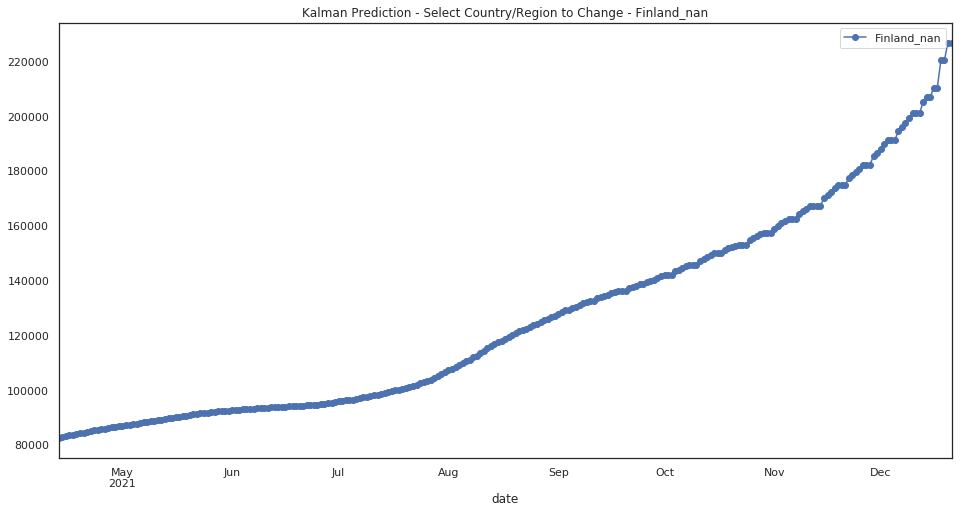

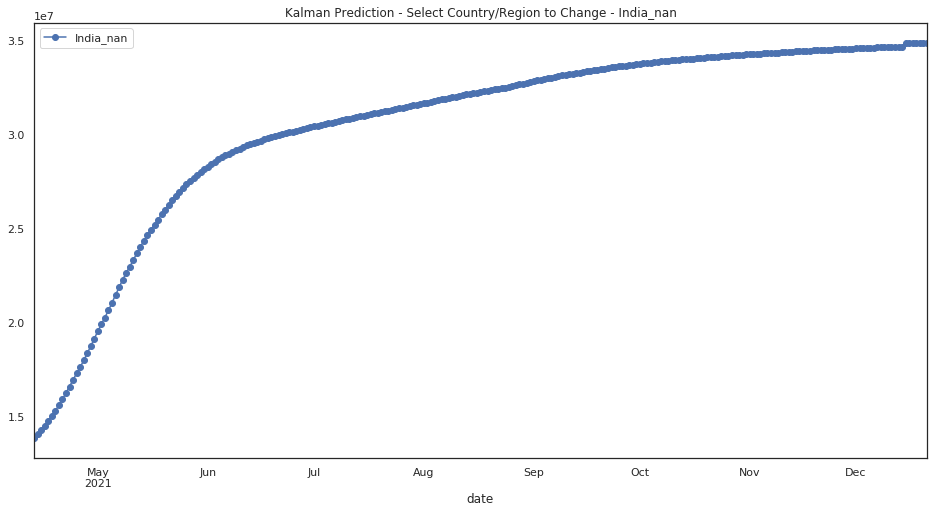

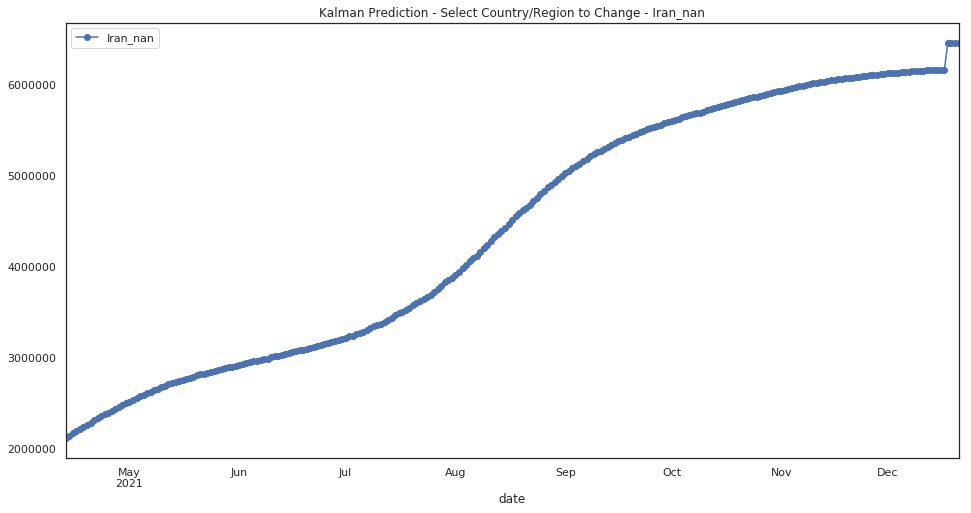

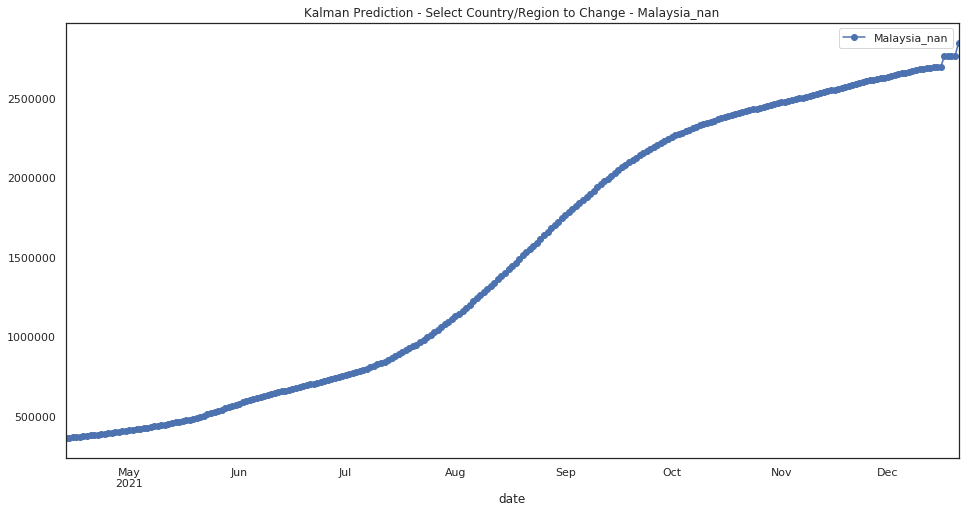

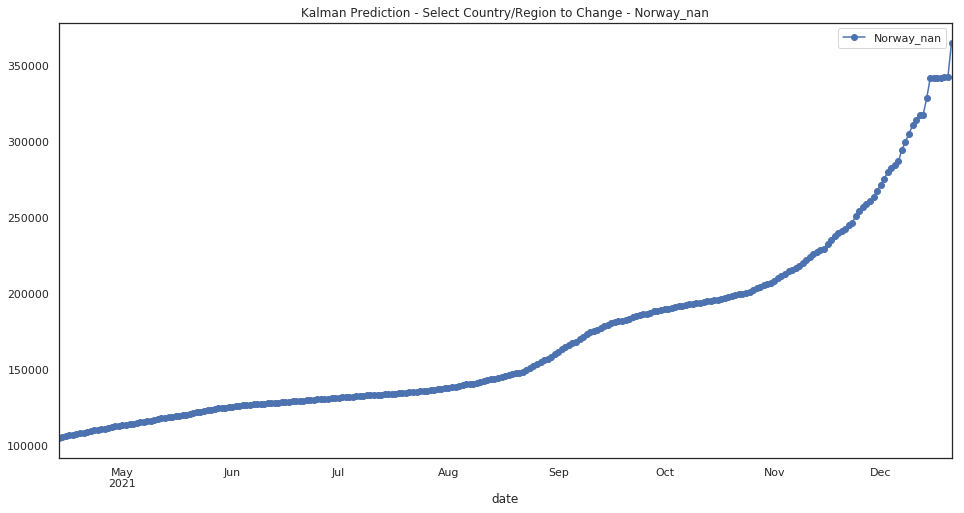

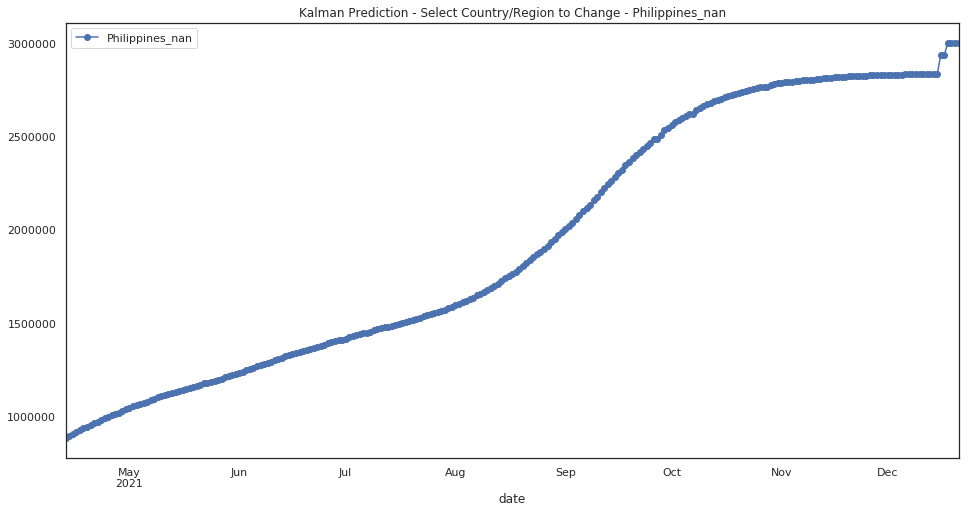

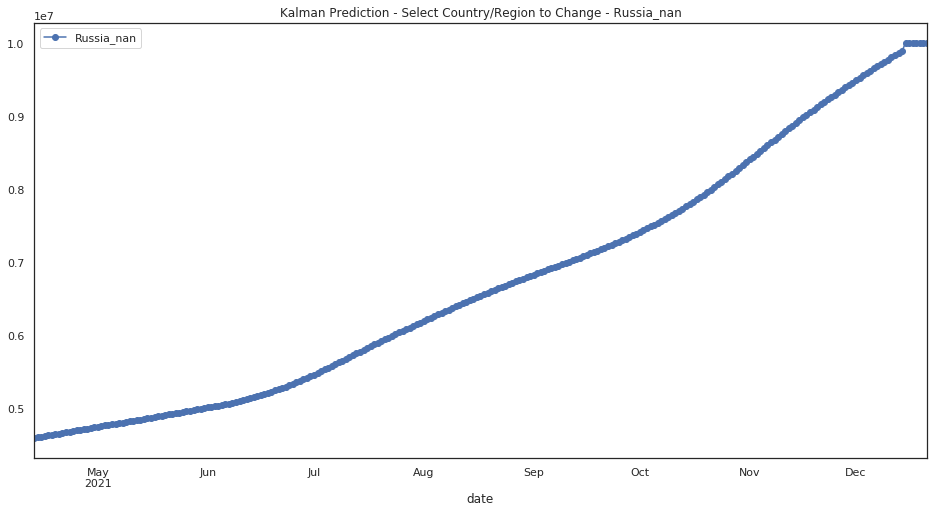

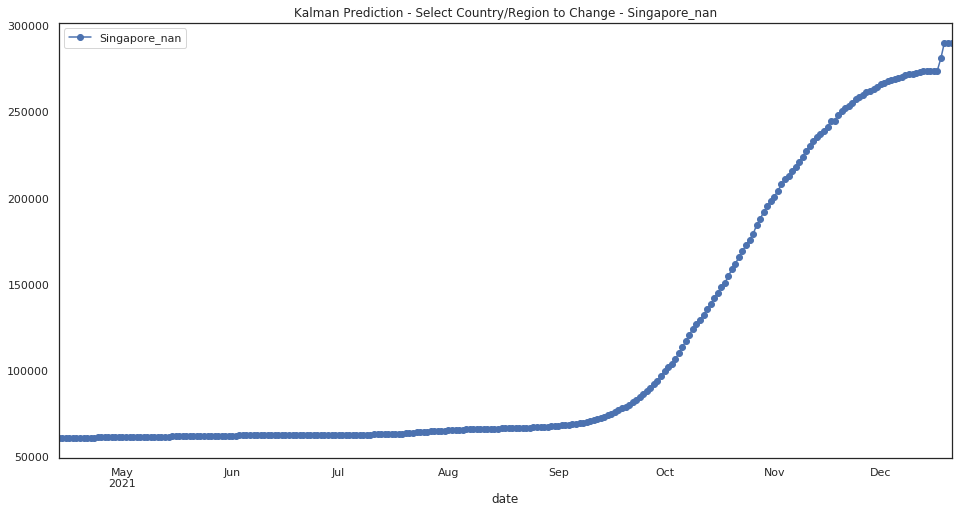

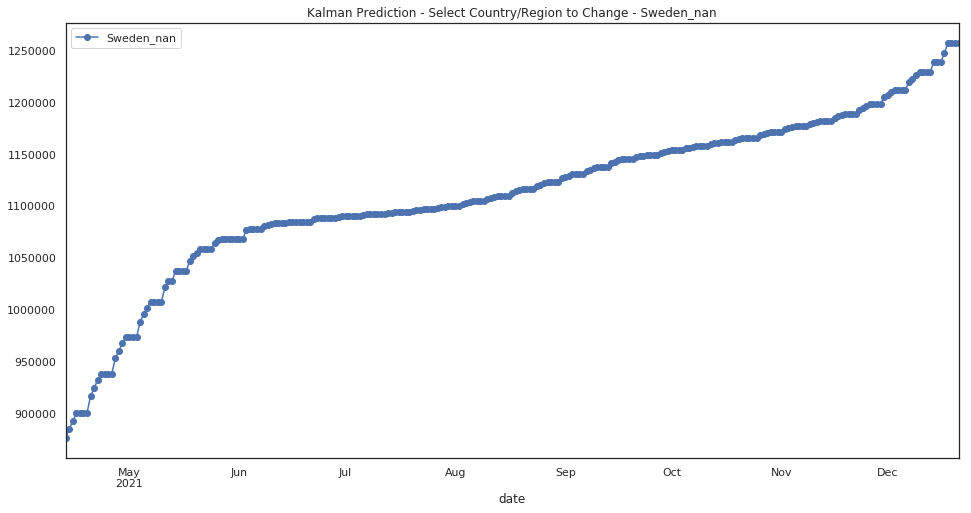

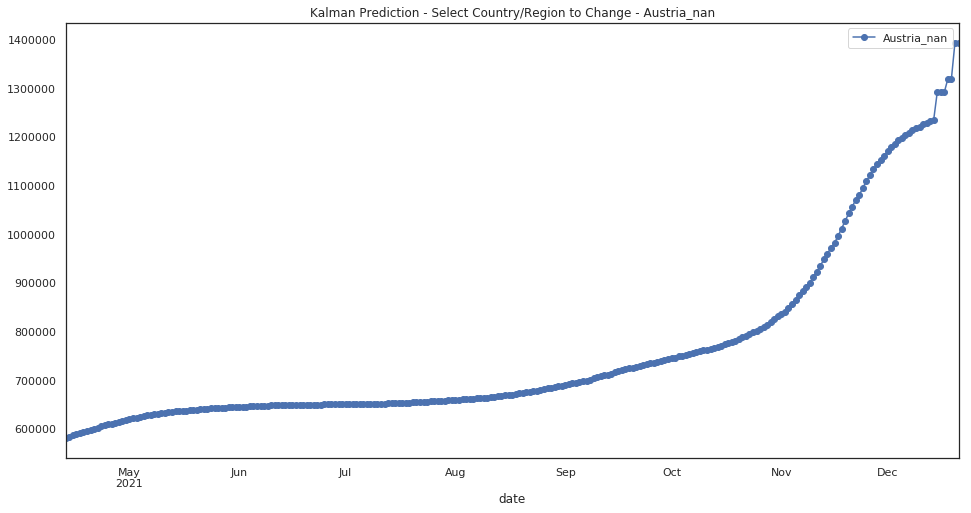

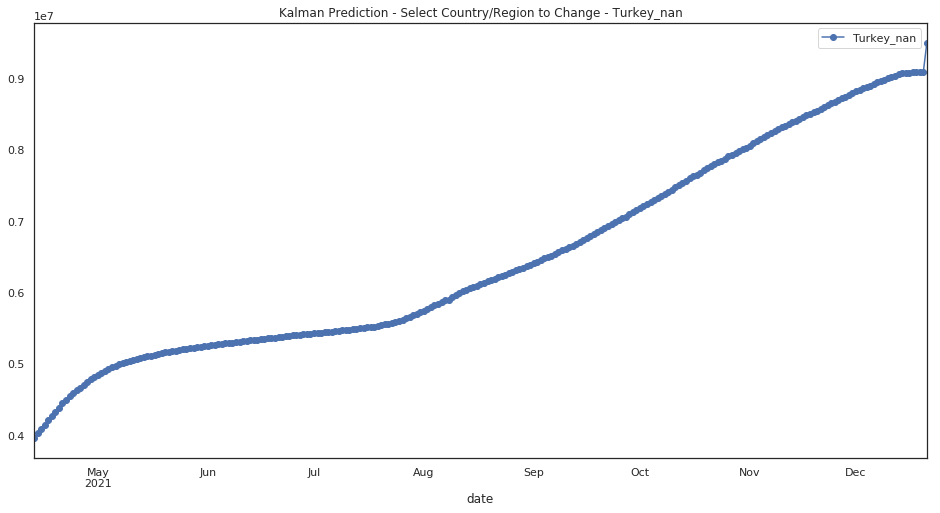

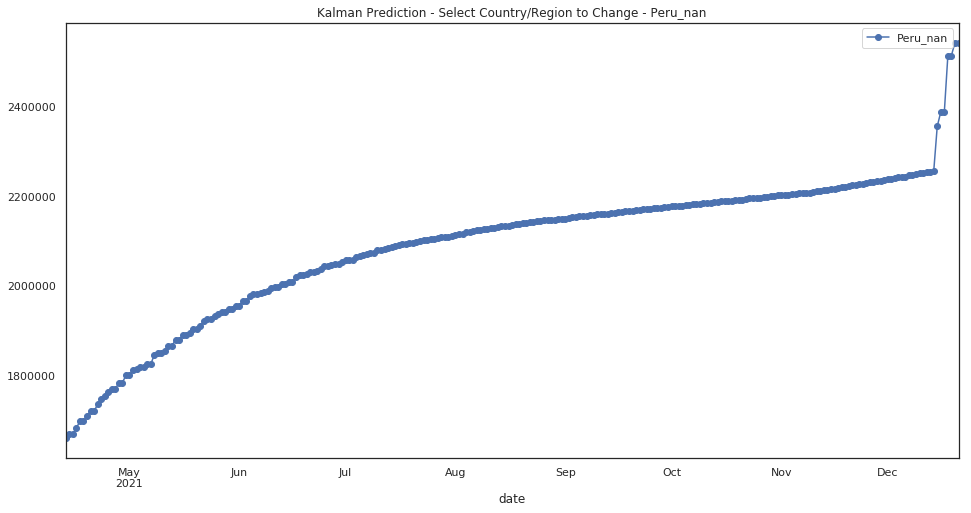

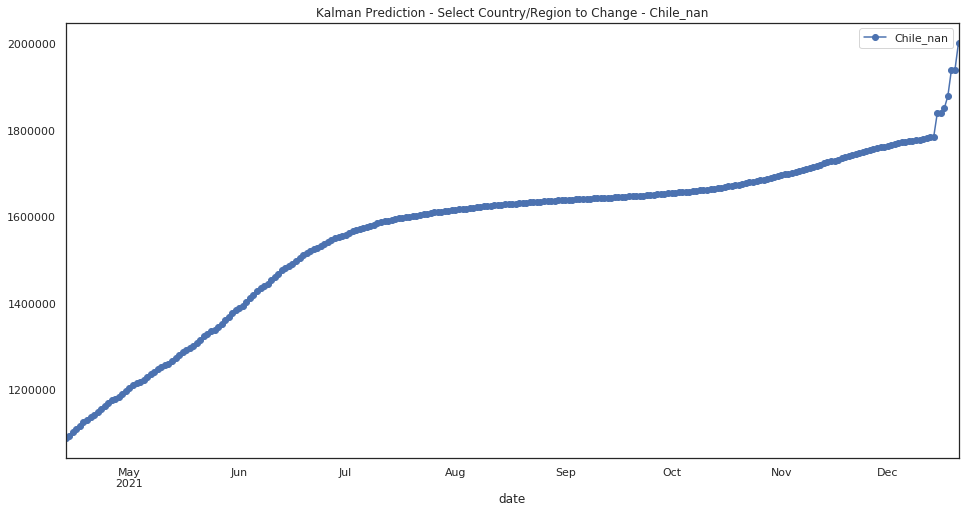

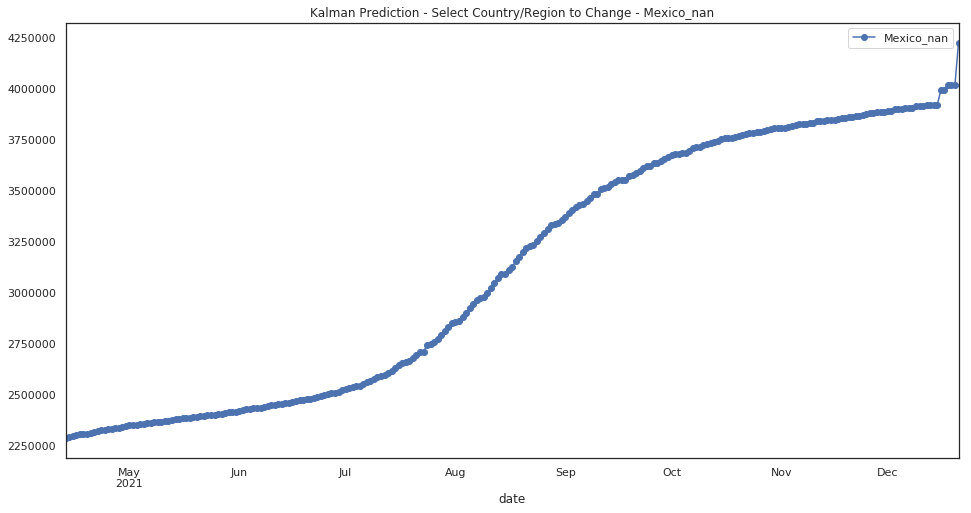

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-12-21 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      51746747.0
India_nan                                           NaN      34918012.0
Brazil_nan                                          NaN      23749003.0
United Kingdom_nan                                  NaN      11512115.0
Russia_nan                                          NaN      10016200.0
Turkey_nan                                          NaN       9504944.0
France_nan                                          NaN       8136637.0
Germany_nan                                         NaN       6959907.0
Iran_nan                                            NaN       6460979.0
Italy_nan                                           NaN       6335733.0
Argentina_nan                                       NaN       5483054.0
Colombia_nan                                        NaN       5454878.0
Spain_nan                                           NaN       5424118.0
Indonesia_nan                                       NaN       4517885.0
Poland_nan                                          NaN       4355327.0
Mexico_nan                                          NaN       4224704.0
Ukraine_nan                                         NaN       4021019.0
South Africa_nan                                    NaN       3313575.0
Netherlands_nan                                     NaN       3056134.0
Philippines_nan                                     NaN       3006364.0
Malaysia_nan                                        NaN       2852690.0
Czechia_nan                                         NaN       2679652.0
Peru_nan                                            NaN       2543432.0
Thailand_nan                                        NaN       2451459.0
Iraq_nan                                            NaN       2212046.0
Belgium_nan                                         NaN       2031682.0
Chile_nan                                           NaN       2003238.0
Romania_nan                                         NaN       1891036.0
Japan_nan                                           NaN       1854243.0
Bangladesh_nan                                      NaN       1602623.0
...                                                 ...             ...
France_Wallis and Futuna                            NaN           471.0
Australia_Northern Territory                        NaN           389.0
China_Gansu                                         NaN           386.0
China_Shanxi                                        NaN           277.0
Australia_Tasmania                                  NaN           248.0
China_Hainan                                        NaN           212.0
China_Guizhou                                       NaN           179.0
China_Ningxia                                       NaN           122.0
France_Saint Pierre and Miquelon                    NaN           102.0
United Kingdom_Falkland Islands (Malvinas)          NaN            91.0
China_Macau                                         NaN            83.0
United Kingdom_Montserrat                           NaN            47.0
China_Unknown                                       NaN            37.0
China_Qinghai                                       NaN            31.0
Holy See_nan                                        NaN            30.0
Solomon Islands_nan                                 NaN            21.0
Canada_Grand Princess                               NaN            13.0
Canada_Repatriated Travellers                       NaN            13.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             7.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         120135.0     181545.0     172983.0      81641.0   
2021-04-14         120246.0     181723.0     173134.0      81664.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          57657.0     129307.0     119387.0      12712.0   
2021-04-18          57721.0     129456.0     119552.0      12771.0   
2021-04-19          57842.0     129594.0     119718.0      12805.0   
2021-04-20          57939.0     129694.0     119898.0      12805.0   
2021-04-21          59079.0     130559.0     121077.0      12874.0   
2021-04-22          59151.0     130696.0     121268.0      12917.0   
2021-04-23          59453.0     130850.0     121463.0      12942.0   
2021-04-24          59506.0     130981.0     121636.0      13007.0   
2021-04-25          59680.0     131117.0     121832.0      13024.0   
2021-04-26          59929.0     131199.0     122017.0      13060.0   
2021-04-27          60068.0     131344.0     122241.0      13083.0   
2021-04-28          60183.0     131441.0     122459.0      13121.0   
2021-04-29          60453.0     131562.0     122737.0      13148.0   
2021-04-30          60564.0     131674.0     122965.0      13198.0   
2021-05-01          60793.0     131778.0     123194.0      13232.0   
2021-05-02          60953.0     131840.0     123423.0      13232.0   
2021-05-03          61145.0     131898.0     123616.0      13282.0   
2021-05-04          61402.0     131952.0     123893.0      13295.0   
2021-05-05          61552.0     132031.0     124129.0      13316.0   
2021-05-06          61936.0     132105.0     124345.0      13340.0   
2021-05-07          62110.0     132175.0     124593.0      13363.0   
2021-05-08          62492.0     132270.0     124794.0      13390.0   
2021-05-09          62608.0     132322.0     125003.0      13406.0   
2021-05-10          63024.0     132369.0     125192.0      13423.0   
2021-05-11          63204.0     132427.0     125394.0      13429.0   
2021-05-12          63401.0     132461.0     125586.0      13447.0   
...                     ...          ...          ...          ...   
2021-11-23         157972.0     197420.0     210192.0      16299.0   
2021-11-24         157973.0     198035.0     210368.0      16342.0   
2021-11-25         158099.0     198549.0     210531.0      16426.0   
2021-11-26         158109.0     199019.0     210723.0      16566.0   
2021-11-27         158156.0     199445.0     210884.0      16712.0   
2021-11-28         158185.0     199868.0     211061.0      16712.0   
2021-11-29         158222.0     200096.0     211249.0      16712.0   
2021-11-30         158248.0     200336.0     211433.0      16712.0   
2021-12-01         158316.0     200555.0     211626.0      17115.0   
2021-12-02         158337.0     200975.0     211822.0      17426.0   
2021-12-03         158375.0     201333.0     212013.0      17658.0   
2021-12-04         158396.0     201708.0     212200.0      18010.0   
2021-12-05         158412.0     202049.0     212375.0      18010.0   
2021-12-06         158462.0     202248.0     212568.0      18010.0   
2021-12-07         158464.0     202645.0     212760.0      18631.0   
2021-12-08         158509.0     202950.0     212949.0      18815.0   
2021-12-09         158542.0     203200.0     213129.0      18815.0   
2021-12-10         158780.0     203557.0     213336.0      19272.0   
2021-12-11         158748.0     203842.0     213547.0      19440.0   
2021-12-12         158836.0     204120.0     213744.0      19440.0   
2021-12-13         158655.0     204283.0     213957.0      19440.0   
2021-12-14         158700.0     204653.0     214182.0      19440.0   
2021-12-15         158630.0     213077.0     214210.0      20136.0   
2021-12-16         158633.0     214095.0     214255.0      20136.0   
2021-12-17

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Turkey_nan',
 'France_nan',
 'Germany_nan',
 'Iran_nan',
 'Italy_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Spain_nan',
 'Indonesia_nan',
 'Poland_nan',
 'Mexico_nan',
 'Ukraine_nan',
 'South Africa_nan',
 'Netherlands_nan',
 'Philippines_nan',
 'Malaysia_nan',
 'Czechia_nan',
 'Peru_nan',
 'Thailand_nan',
 'Iraq_nan',
 'Belgium_nan',
 'Chile_nan',
 'Romania_nan',
 'Japan_nan',
 'Bangladesh_nan',
 'Vietnam_nan',
 'Austria_nan',
 'Israel_nan',
 'Pakistan_nan',
 'Slovakia_nan',
 'Hungary_nan',
 'Portugal_nan',
 'Serbia_nan',
 'Sweden_nan',
 'Kazakhstan_nan',
 'Switzerland_nan',
 'Greece_nan',
 'Cuba_nan',
 'Jordan_nan',
 'Morocco_nan',
 'Georgia_nan',
 'Nepal_nan',
 'Tunisia_nan',
 'United Arab Emirates_nan',
 'Croatia_nan',
 'Bulgaria_nan',
 'Belarus_nan',
 'Canada_Ontario',
 'Lebanon_nan',
 'Ireland_nan',
 'Guatemala_nan',
 'Bolivia_nan',
 'Azerbaijan_nan',
 'Denmark_nan',
 'Sri Lanka_nan',
 'Bur

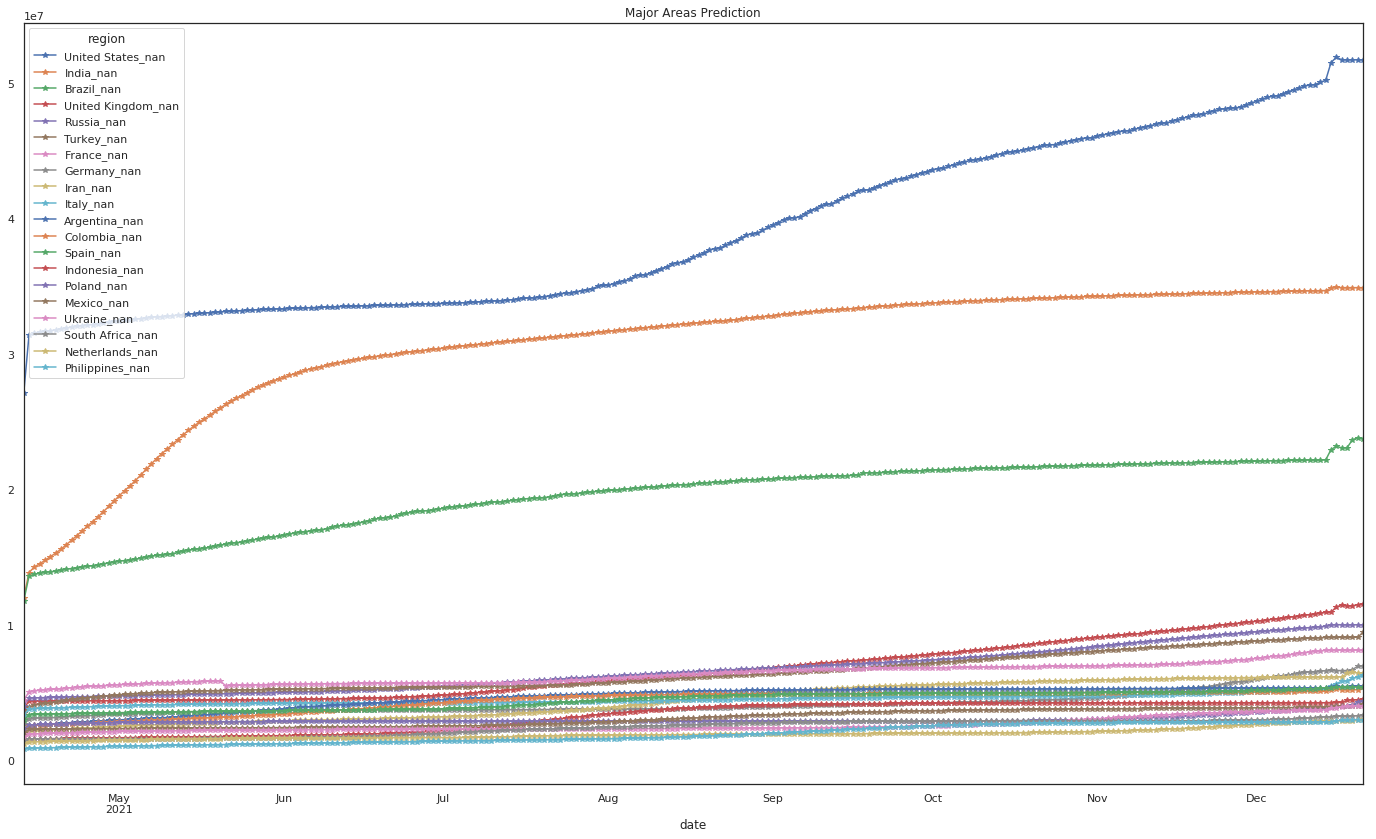

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

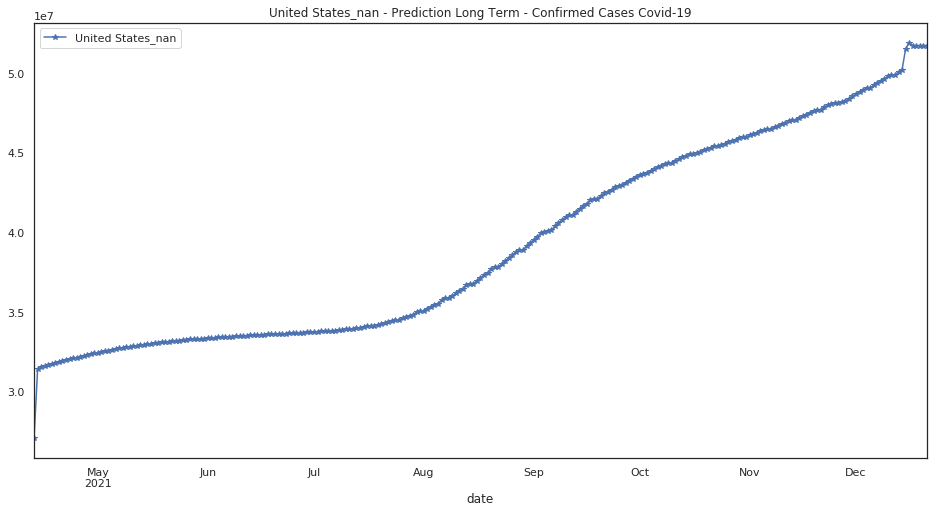

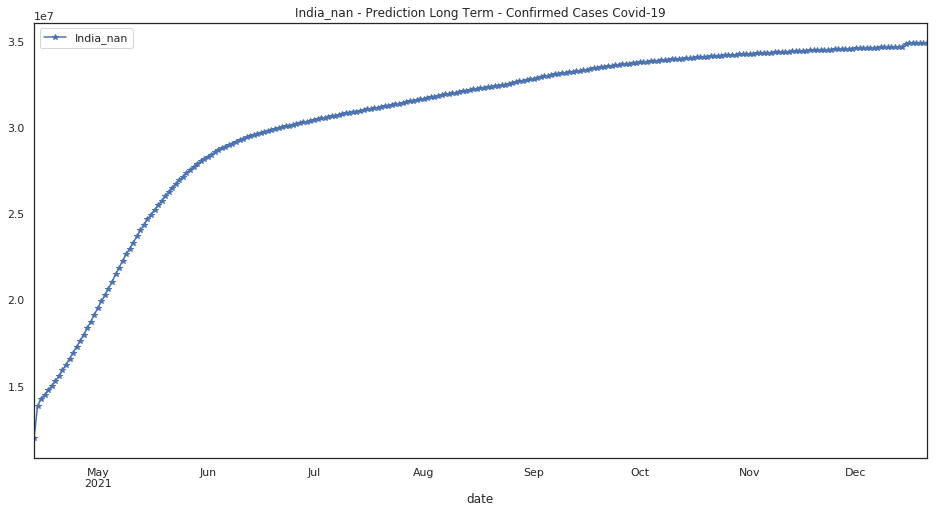

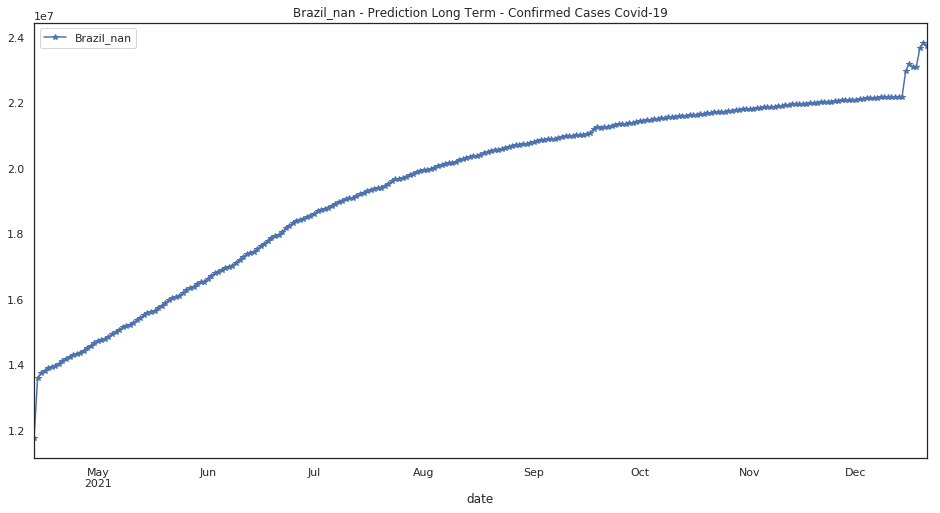

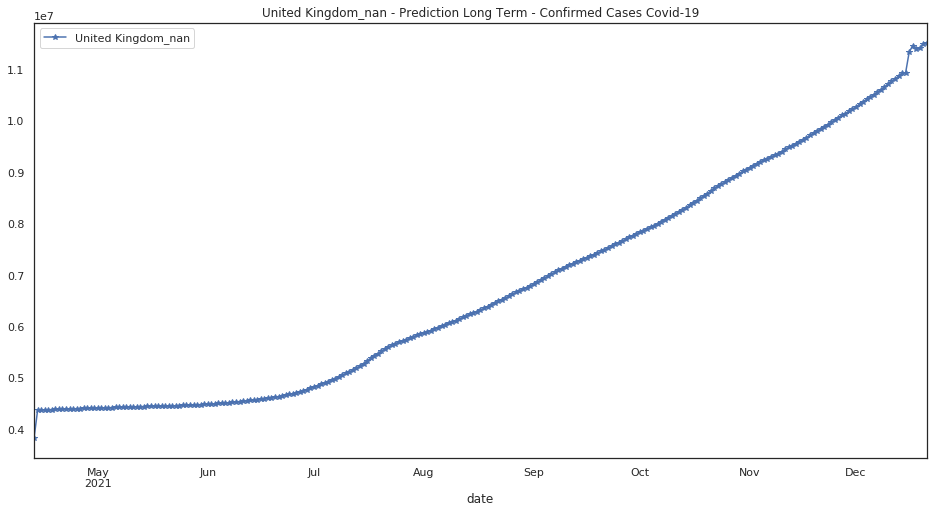

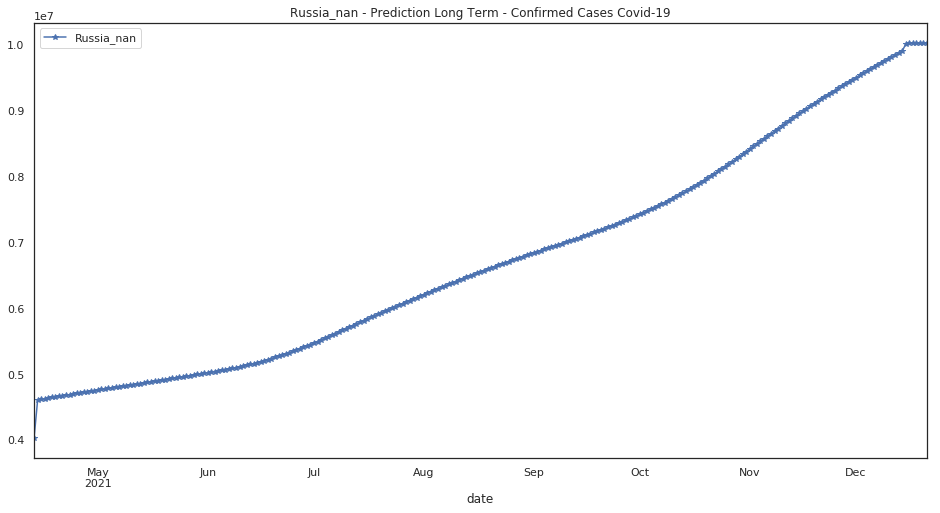

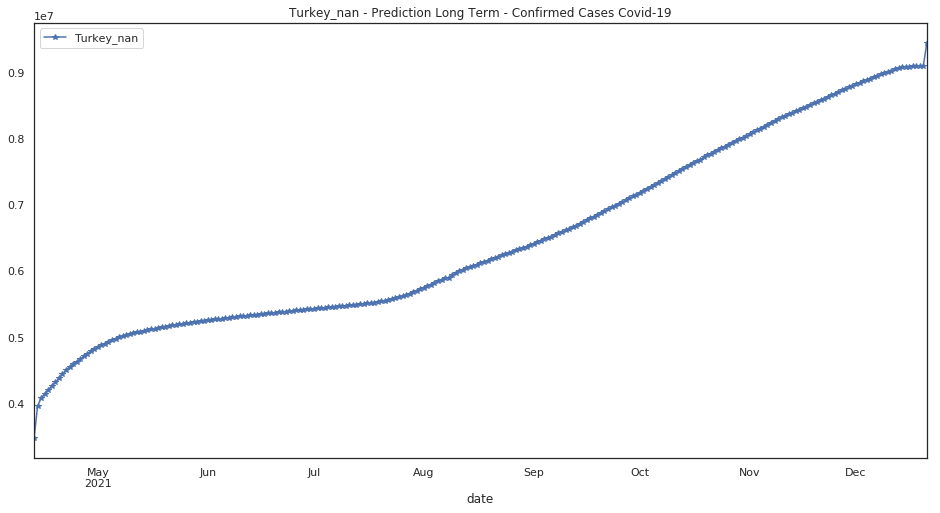

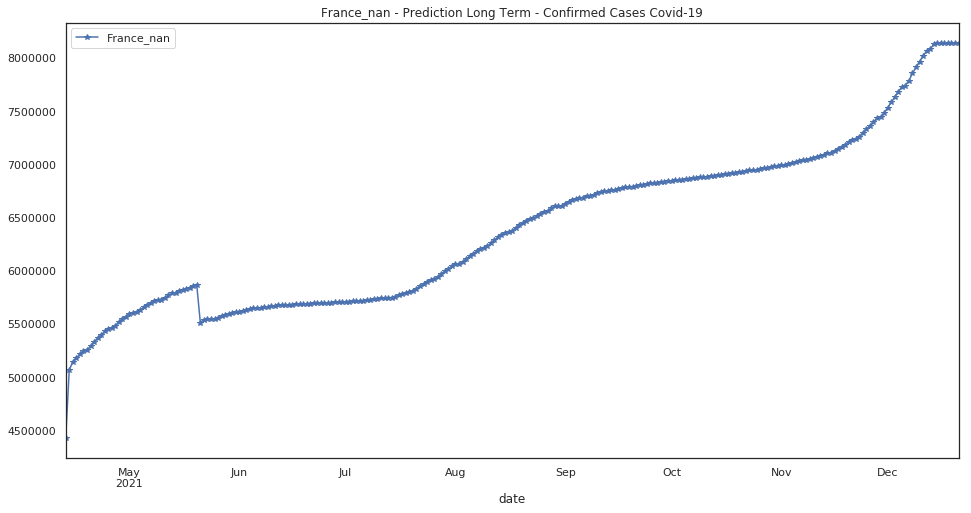

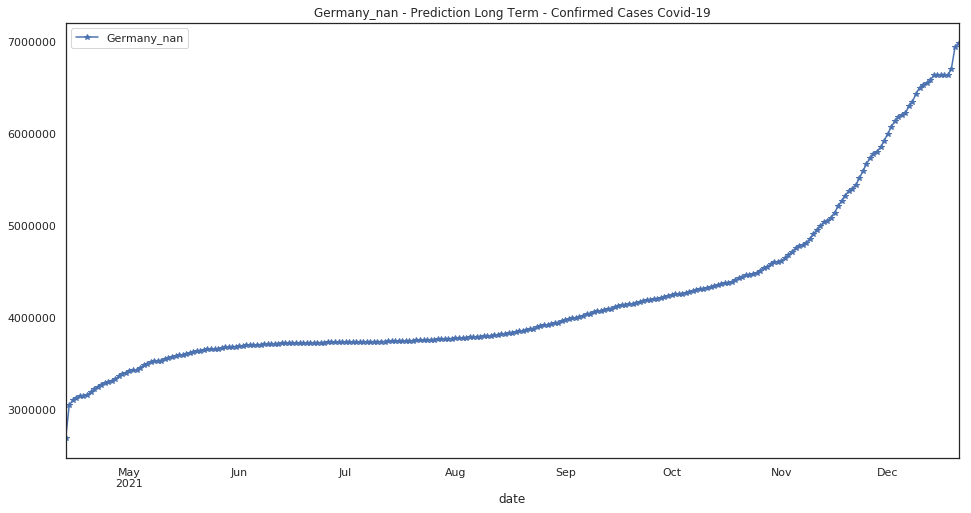

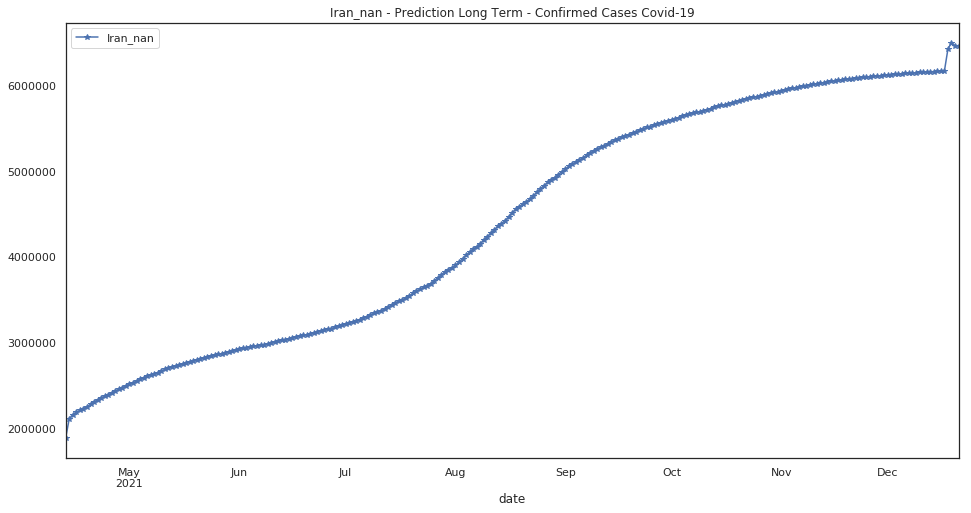

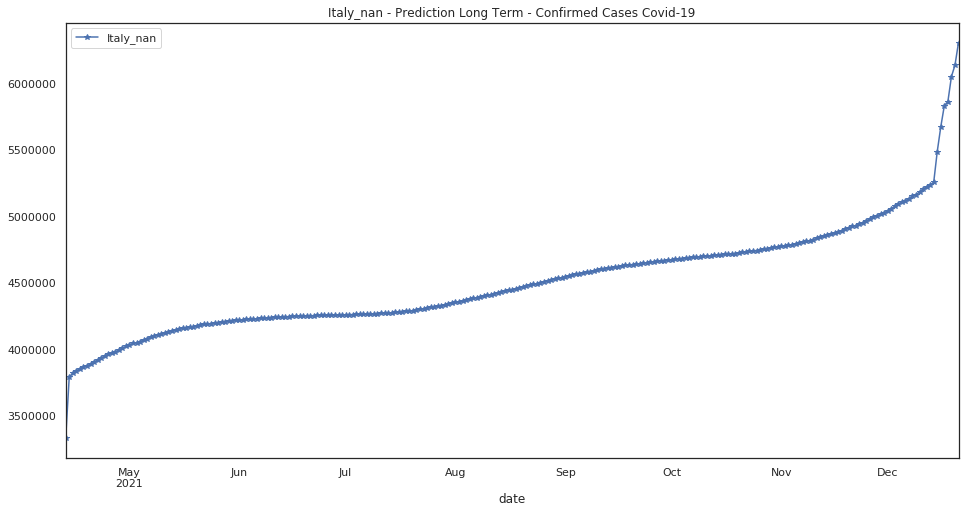

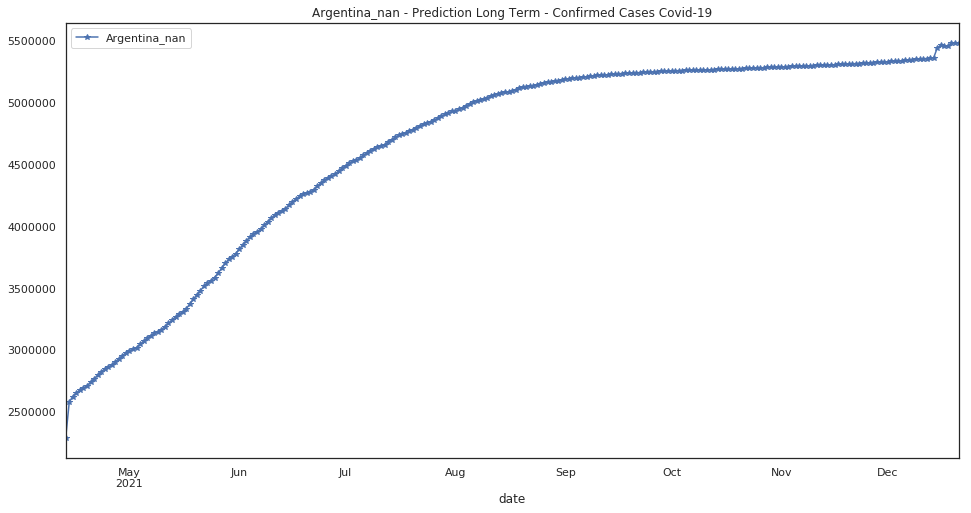

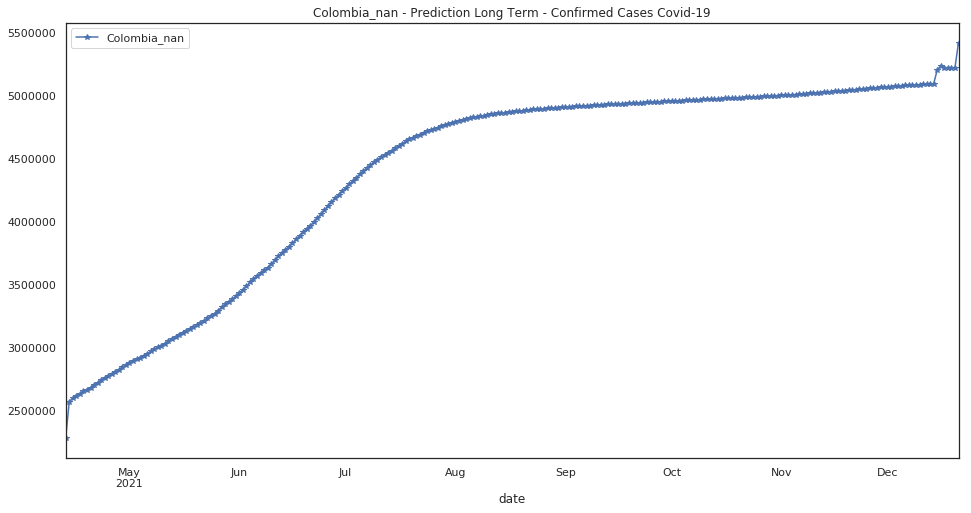

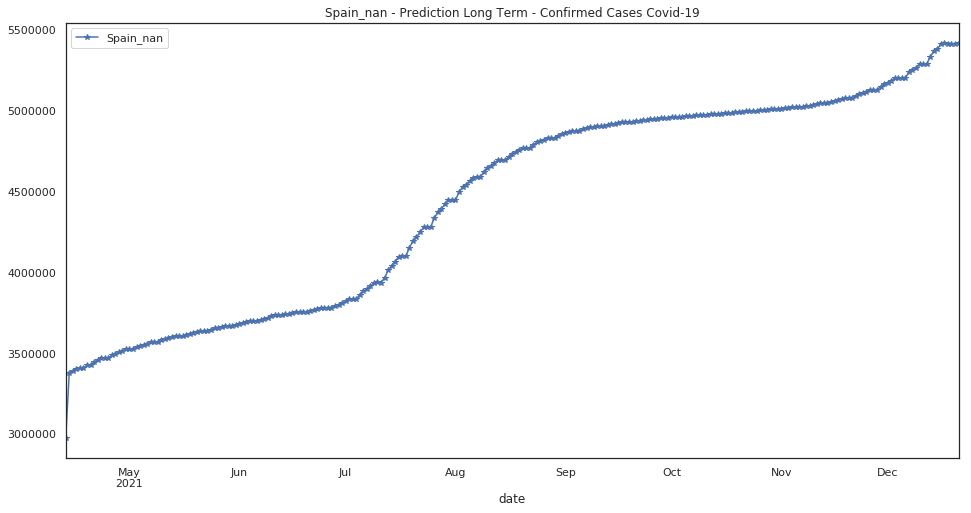

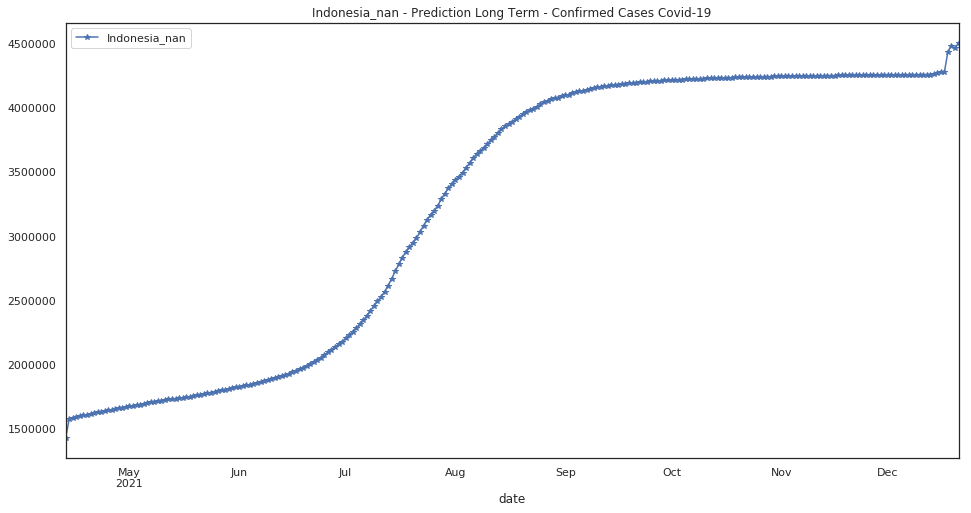

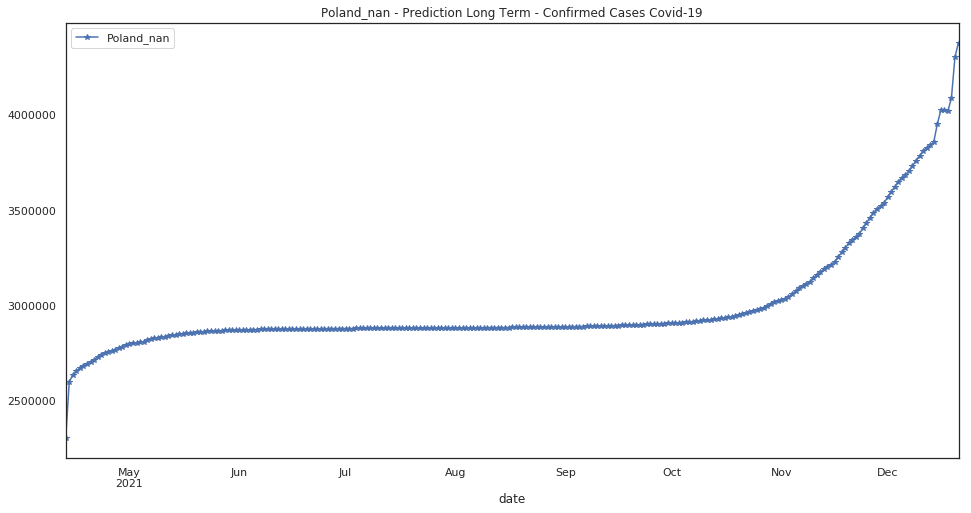

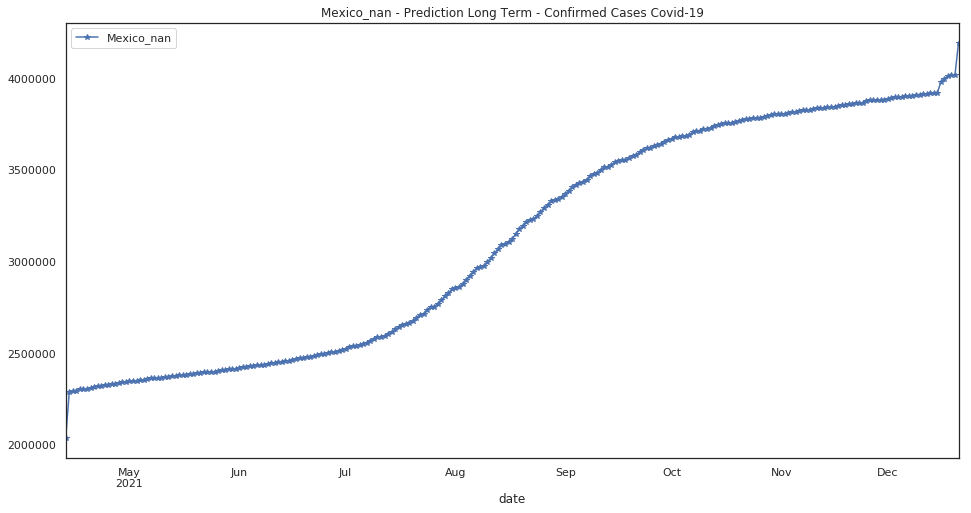

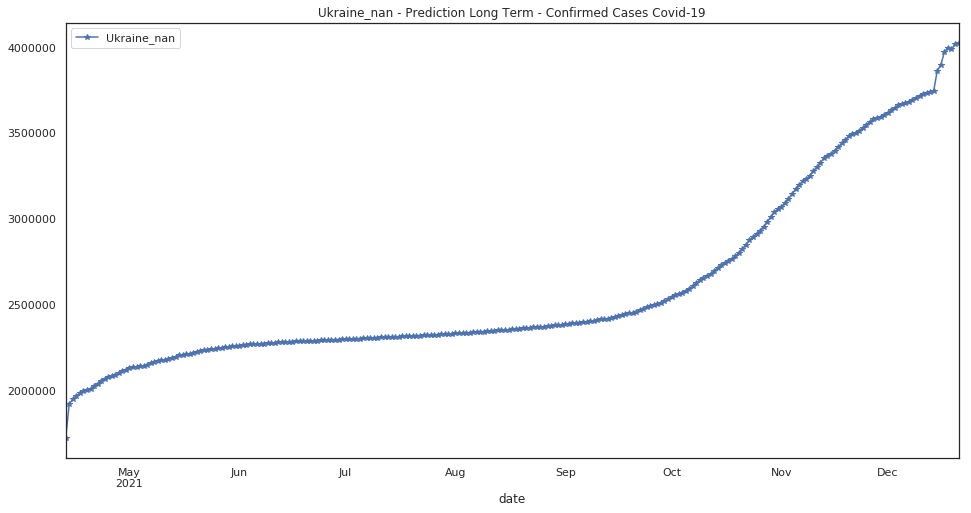

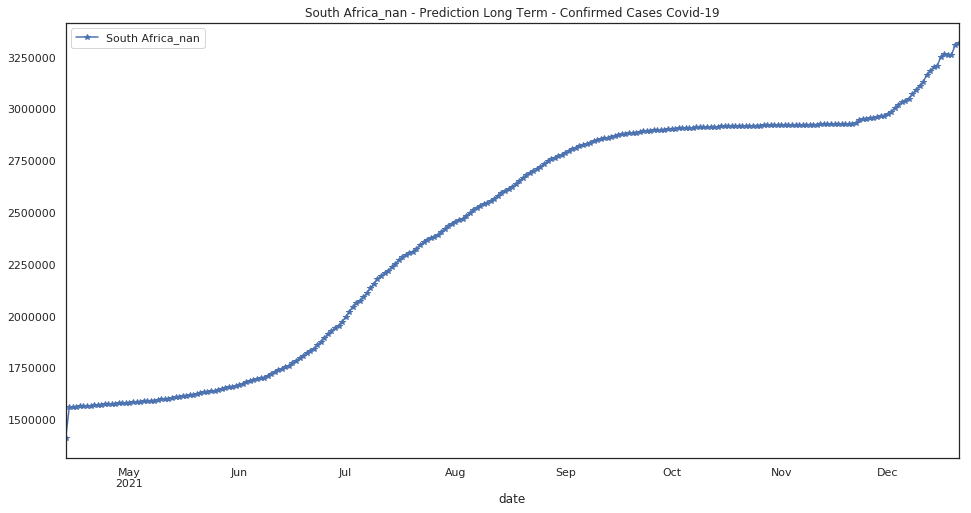

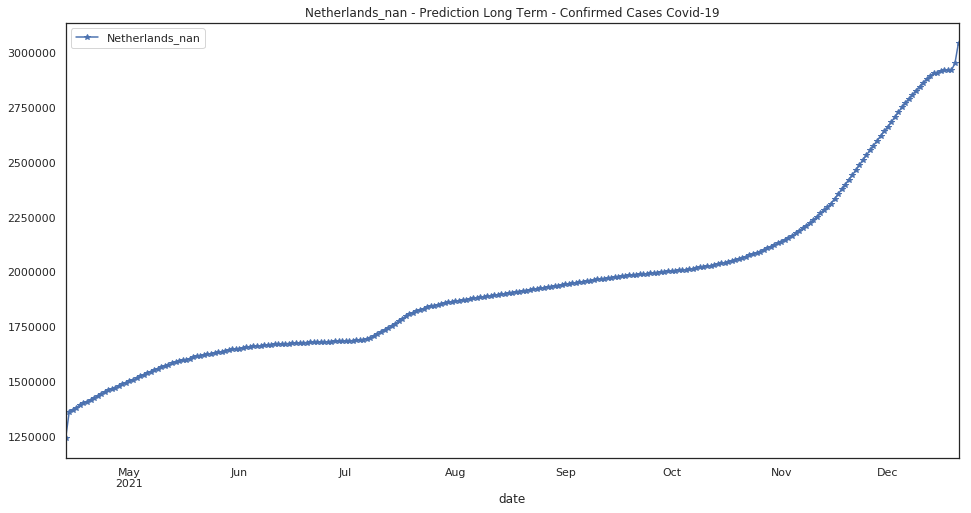

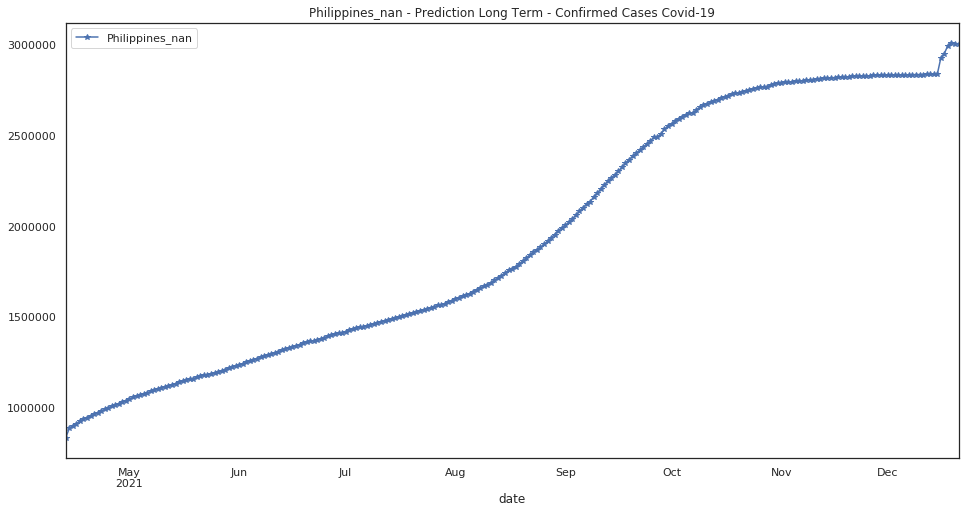

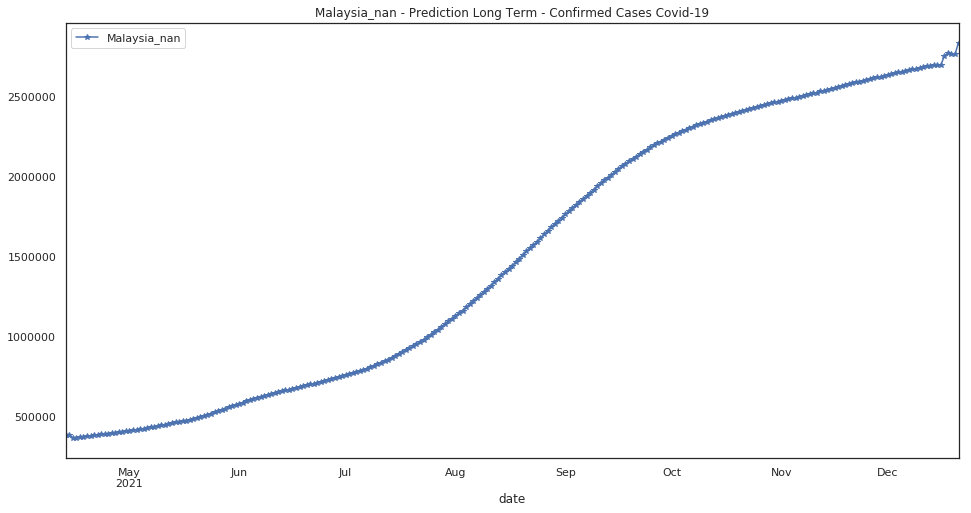

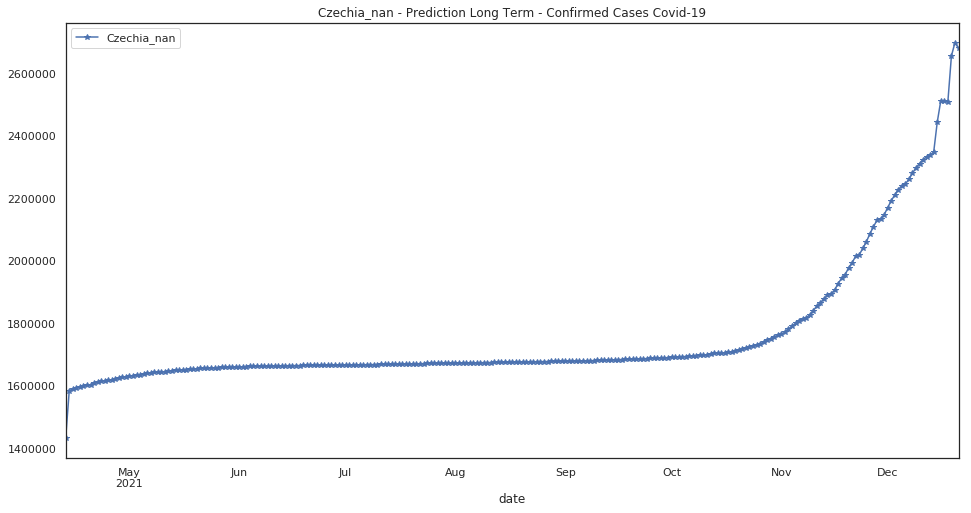

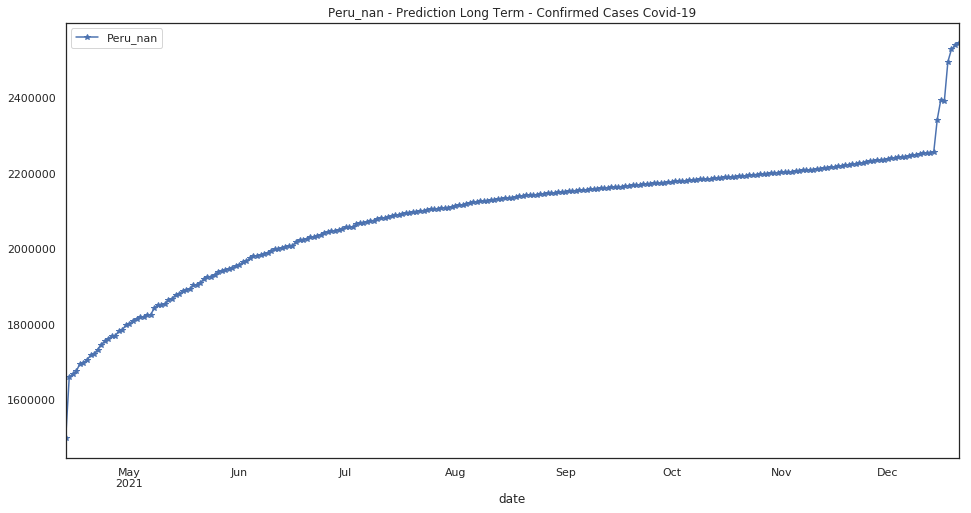

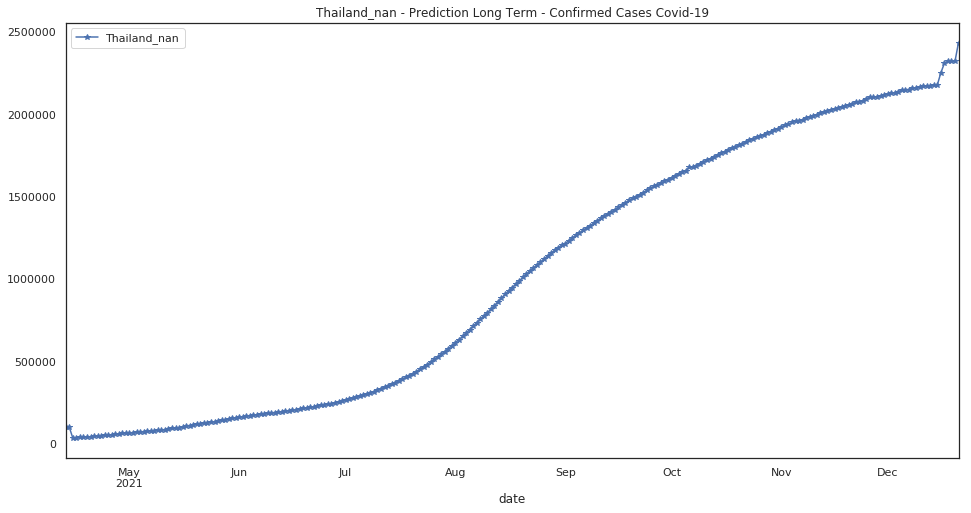

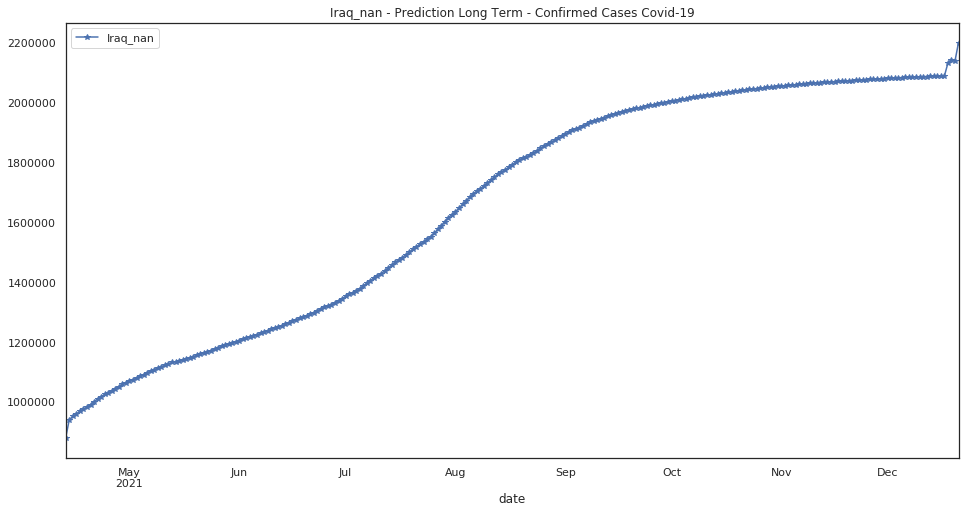

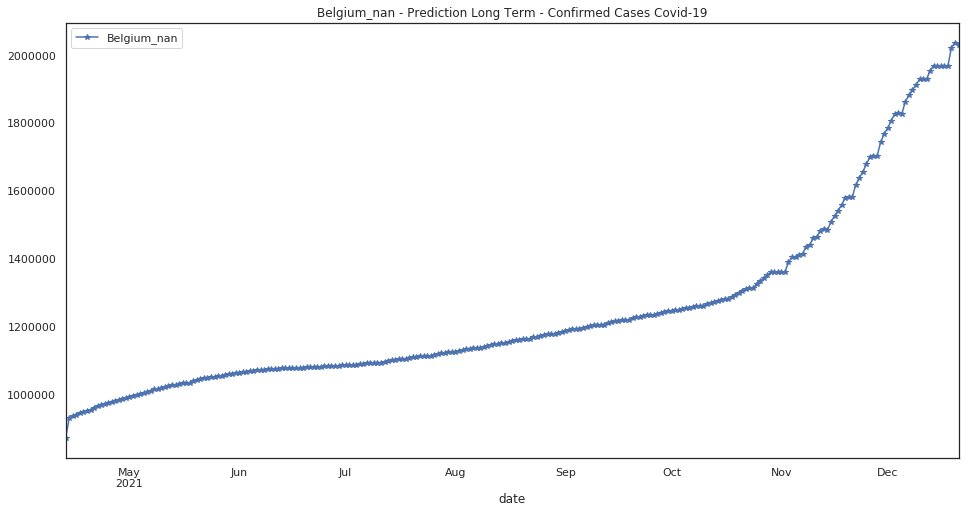

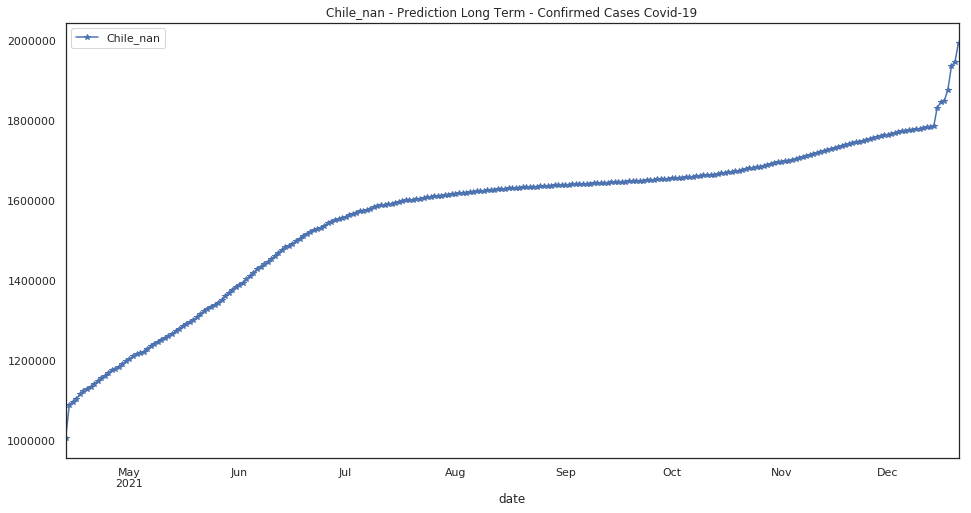

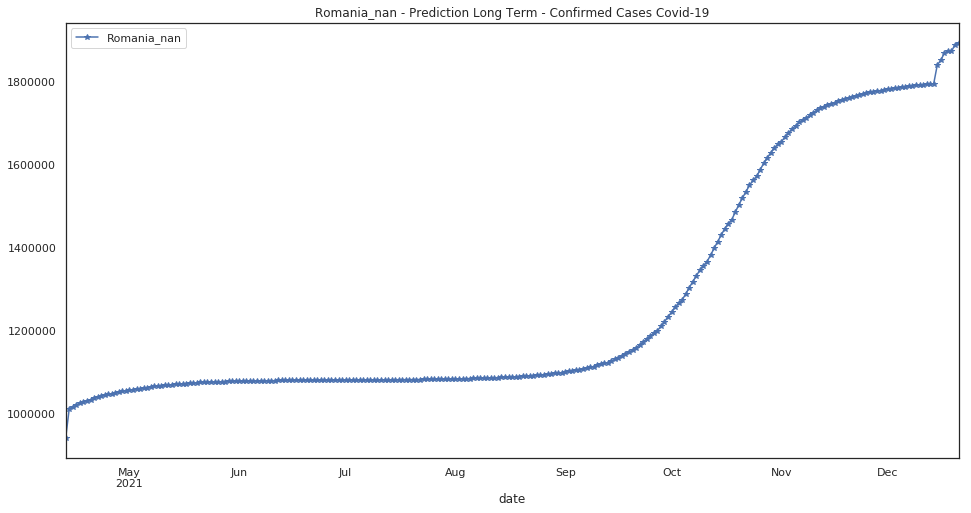

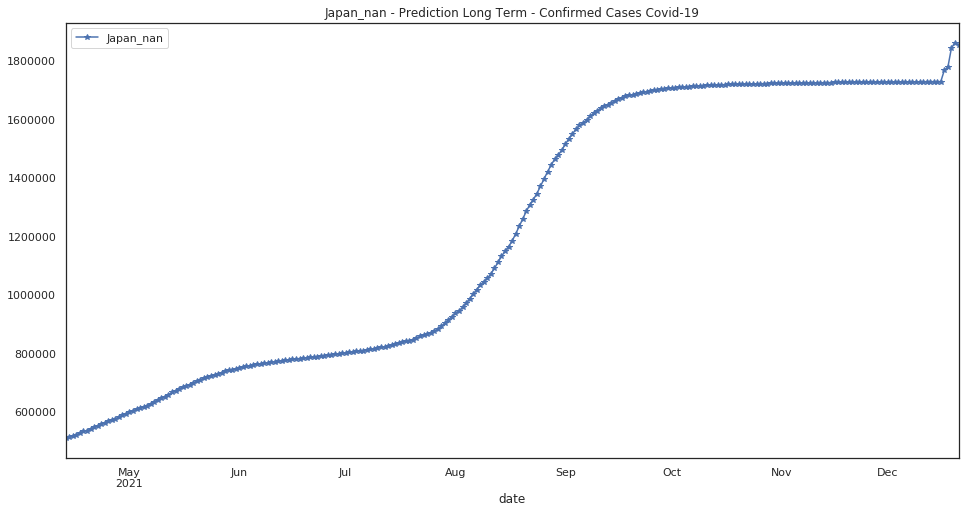

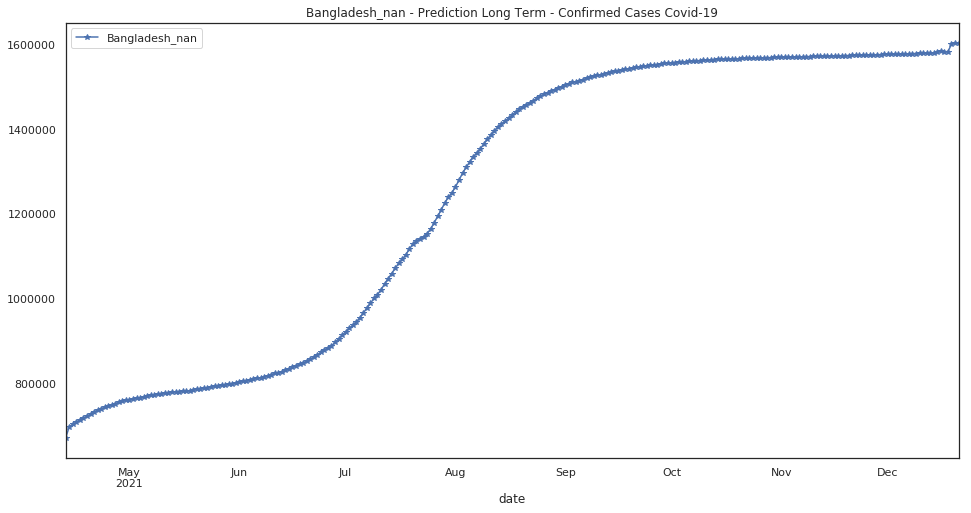

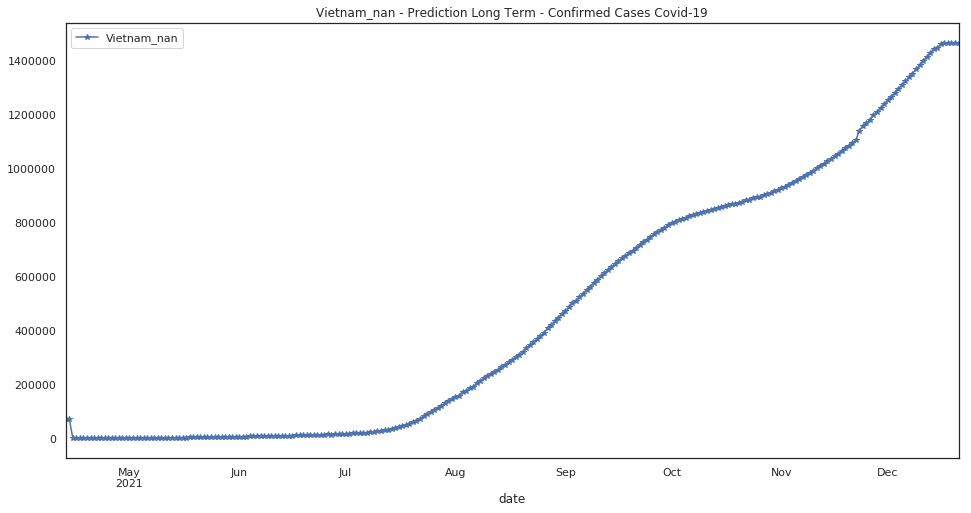

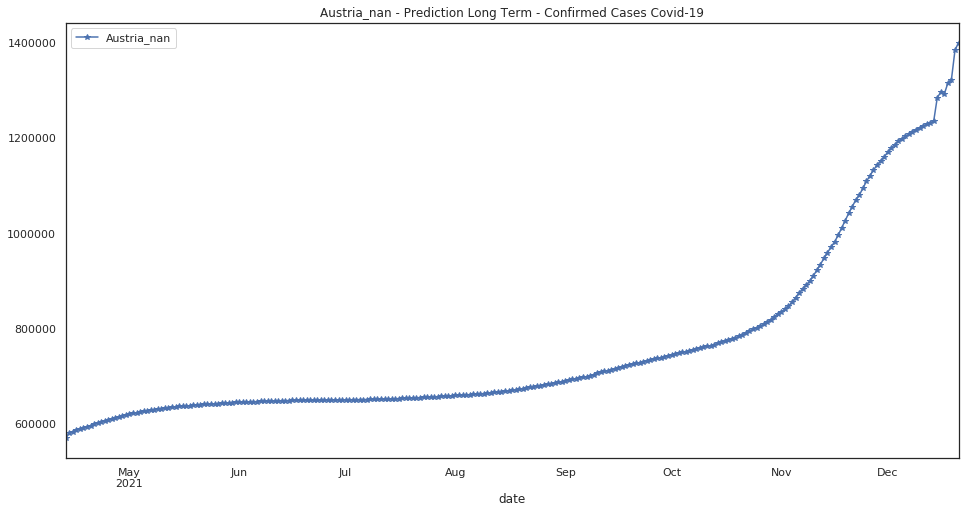

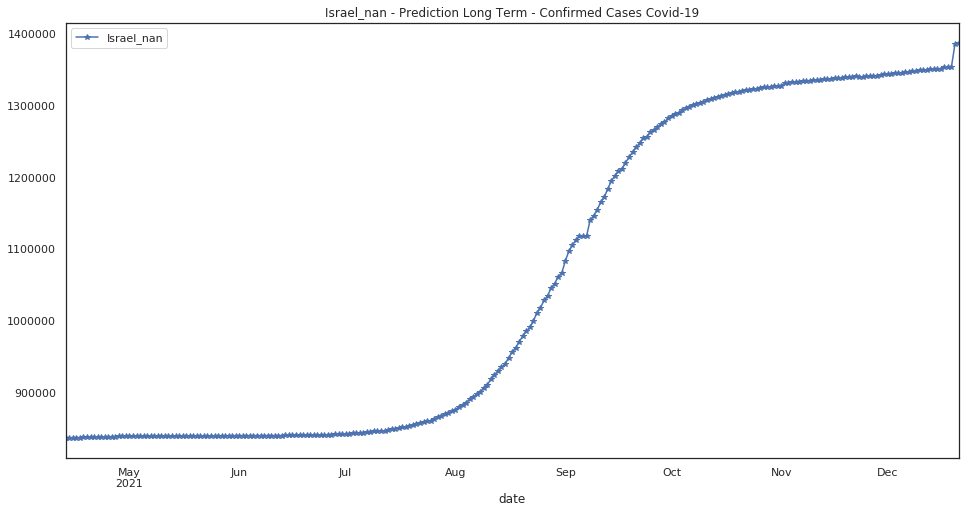

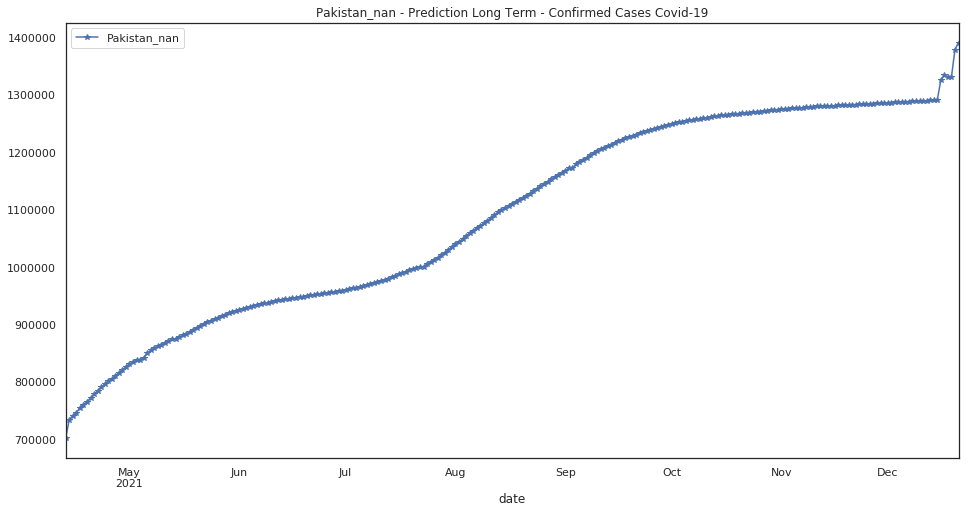

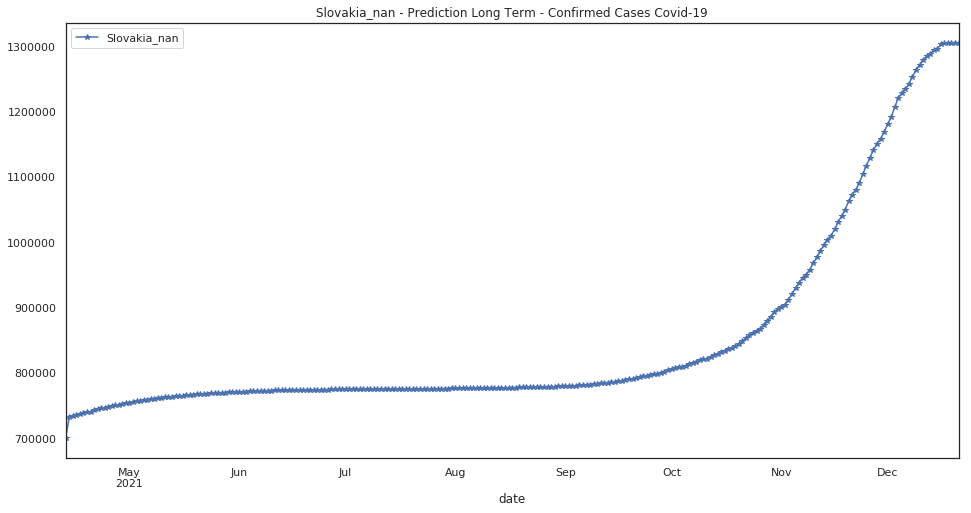

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

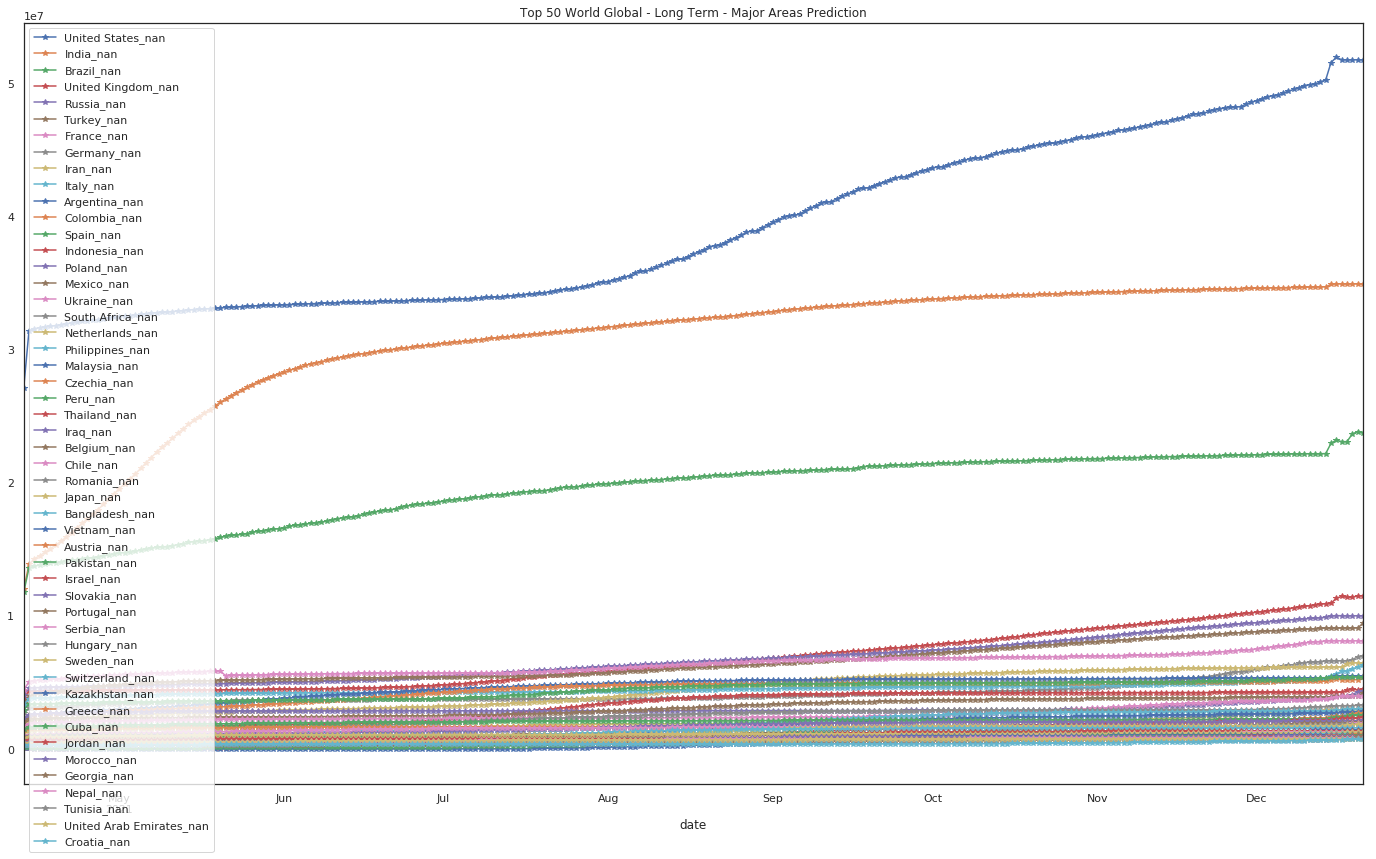

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

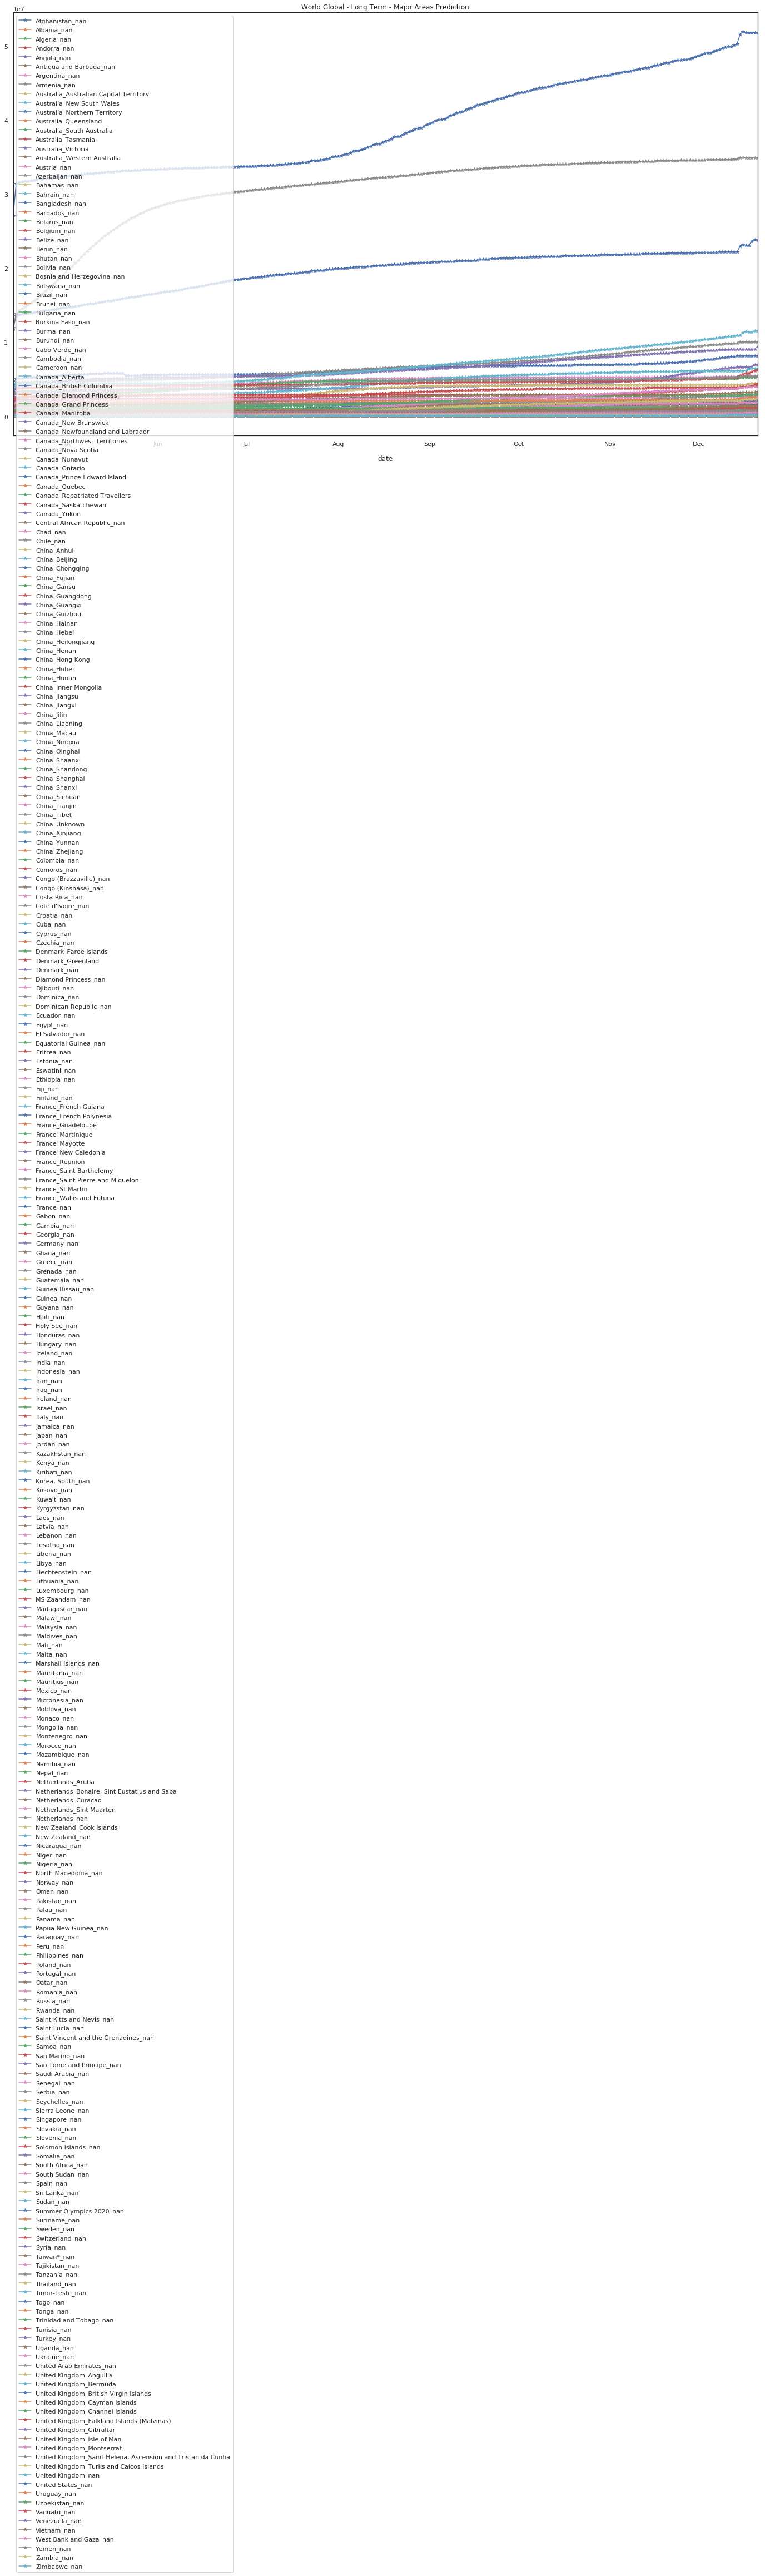

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69601.0     132910.0     129062.0      13682.0   
2021-05-29          70434.0     132922.0     129325.0      13693.0   
2021-05-30          70954.0     132938.0     129600.0      13693.0   
2021-05-31          72296.0     132944.0     129795.0      13693.0   
2021-06-01          73067.0     132966.0     130117.0      13727.0   
2021-06-02          74104.0     132975.0     130474.0      13729.0   
2021-06-03          75300.0     132988.0     130775.0      13744.0   
2021-06-04          76736.0     133001.0     131192.0      13752.0   
2021-06-05          77784.0     133003.0     131503.0      13758.0   
2021-06-06          79238.0     133012.0     131814.0      13758.0   
2021-06-07          80901.0     133015.0     132151.0      13758.0   
2021-06-08          82151.0     133027.0     132491.0      13777.0   
2021-06-09          83979.0     133041.0     132860.0      13781.0   
2021-06-10          85668.0     133051.0     133181.0      13791.0   
2021-06-11          87454.0     133065.0     133573.0      13805.0   
2021-06-12          88644.0     133077.0     133899.0      13813.0   
2021-06-13          90315.0     133087.0     134233.0      13813.0   
2021-06-14          91765.0     133091.0     134593.0      13813.0   
2021-06-15          93226.0     133101.0     134949.0      13826.0   
2021-06-16          93388.0     133106.0     135289.0      13828.0   
2021-06-17          97317.0     133111.0     135678.0      13836.0   
2021-06-18          97620.0     133115.0     136043.0      13839.0   
2021-06-19         100206.0     133120.0     136413.0      13842.0   
2021-06-20         101978.0     133121.0     136672.0      13842.0   
2021-06-21         104116.0     133122.0     137163.0      13842.0   
2021-06-22         105640.0     133128.0     137468.0      13864.0   
2021-06-23         107905.0     133128.0     137876.0      13864.0   
2021-06-24         109440.0     133131.0     138239.0      13873.0   
2021-06-25         111760.0     133137.0     138612.0      13877.0   
2021-06-26         113116.0     133139.0     138951.0      13882.0   
...                     ...          ...          ...          ...   
2021-11-22         157876.0     196996.0     210031.0      16086.0   
2021-11-23         157972.0     197420.0     210192.0      16299.0   
2021-11-24         157973.0     198035.0     210368.0      16342.0   
2021-11-25         158099.0     198549.0     210531.0      16426.0   
2021-11-26         158109.0     199019.0     210723.0      16566.0   
2021-11-27         158156.0     199445.0     210884.0      16712.0   
2021-11-28         158185.0     199868.0     211061.0      16712.0   
2021-11-29         158222.0     200096.0     211249.0      16712.0   
2021-11-30         158248.0     200336.0     211433.0      16712.0   
2021-12-01         158316.0     200555.0     211626.0      17115.0   
2021-12-02         158337.0     200975.0     211822.0      17426.0   
2021-12-03         158375.0     201333.0     212013.0      17658.0   
2021-12-04         158396.0     201708.0     212200.0      18010.0   
2021-12-05         158412.0     202049.0     212375.0      18010.0   
2021-12-06         158462.0     202248.0     212568.0      18010.0   
2021-12-07         158464.0     202645.0     212760.0      18631.0   
2021-12-08         158509.0     202950.0     212949.0      18815.0   
2021-12-09         158542.0     203200.0     213129.0      18815.0   
2021-12-10         158780.0     203557.0     213336.0      19272.0   
2021-12-11         158748.0     203842.0     213547.0      19440.0   
2021-12-12         158836.0     204120.0     213744.0      19440.0   
2021-12-13         158655.0     204283.0     213957.0      19440.0   
2021-12-14         158700.0     204653.0     214182.0      19440.0   
2021-12-15         158630.0     213077.0     214210.0      20136.0   
2021-12-16

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      30                Brazil_nan -14.235000  -51.925300   
5      59                 Chile_nan -35.675100  -71.543000   
6      94              Colombia_nan   4.570900  -74.297300   
7     100               Croatia_nan  45.100000   15.200000   
8     101                  Cuba_nan  21.521757  -77.781167   
9     103               Czechia_nan  49.817500   15.473000   
10    132                France_nan  46.227600    2.213700   
11    135               Georgia_nan  42.315400   43.356900   
12    136               Georgia_nan  42.315400   43.356900   
13    137               Germany_nan  51.165691   10.451526   
14    139                Greece_nan  39.074200   21.824300   
15    149               Hungary_nan  47.162500   19.503300   
16    151                 India_nan  20.593684   78.962880   
17    152             Indonesia_nan  -0.789300  113.921300   
18    153                  Iran_nan  32.427908   53.688046   
19    154                  Iraq_nan  33.223191   43.679291   
20    156                Israel_nan  31.046051   34.851612   
21    157                Israel_nan  31.046051   34.851612   
22    158                 Italy_nan  41.871940   12.567380   
23    160                 Japan_nan  36.204824  138.252924   
24    161                Jordan_nan  31.240000   36.510000   
25    162            Kazakhstan_nan  48.019600   66.923700   
26    182              Malaysia_nan   4.210484  101.975766   
27    189                Mexico_nan  23.634500 -102.552800   
28    195               Morocco_nan  31.791700   -7.092600   
29    198                 Nepal_nan  28.166700   84.250000   
30    203           Netherlands_nan  52.132600    5.291300   
31    212              Pakistan_nan  30.375300   69.345100   
32    217                  Peru_nan  -9.190000  -75.015200   
33    218           Philippines_nan  12.879721  121.774017   
34    219                Poland_nan  51.919400   19.145100   
35    220              Portugal_nan  39.399900   -8.224500   
36    222               Romania_nan  45.943200   24.966800   
37    223                Russia_nan  61.524010  105.318756   
38    233                Serbia_nan  44.016500   21.005900   
39    237              Slovakia_nan  48.669000   19.699000   
40    241          South Africa_nan -30.559500   22.937500   
41    243                 Spain_nan  40.463667   -3.749220   
42    248                Sweden_nan  60.128161   18.643501   
43    249           Switzerland_nan  46.818200    8.227500   
44    254              Thailand_nan  15.870032  100.992541   
45    259               Tunisia_nan  33.886917    9.537499   
46    260                Turkey_nan  38.963700   35.243300   
47    261         United States_nan  40.000000 -100.000000   
48    263               Ukraine_nan  48.379400   31.165600   
49    264  United Arab Emirates_nan  23.424076   53.847818   
50    276        United Kingdom_nan  55.378100   -3.436000   
51    281               Vietnam_nan  14.058324  108.277199   

    2021-04-13 00:00:00  2021-04-14 00:00:00  2021-04-15 00:00:00  \
0             2289293.0            2579000.0            2624119.0   
1              570803.0             581263.0             584205.0   
2              671209.0             697985.0             703359.0   
3              871312.0             930603.0             935316.0   
4            11769757.0           13599994.0           13739722.0   
5             1007318.0            1088710.0            1096939.0   
6             2280961.0            2569314.0            2597849.0   
7              324446.0             327112.0             297973.0   
8              146872.0             147697.0              89404.0   
9             1434268.0    

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()

In [94]:
num_days_R_prediction=14
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)
print(str(ndaysavg)+' '+str(ndayarray)+' '+str(n2dayarray))

14 -15 -29
